# 供应链数据分析

## 简介

这个Notebook是为了展示利用Python对供应链数据分析，并利用机器学习算法分析预测订单欺诈、交付情况。
-- Evan Wang

# 数据导入

数据集来自于DataCo公司全球供应链2015-2018大约 18 万笔交易。 数据集可以从以下地址下载：
https://data.mendeley.com/datasets/8gx2fvg2k6/5

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import svm,tree,preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from IPython.core import display as ICD

import warnings
warnings.filterwarnings('ignore') 


In [2]:
#下载数据，约90M
folder_path = './Data'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print('文件夹已创建')
    url='https://gitee.com/banlangen233/data-sample/releases/download/DataSample/DataCoSupplyChainDataset.csv'
    datafile=requests.get(url)
    open('./Data/DataCoSupplyChainDataset.csv','wb').write(datafile.content)
else:
    print('文件夹已存在')


文件夹已存在


In [3]:
dataset=pd.read_csv("./Data/DataCoSupplyChainDataset.csv",header= 0,encoding= 'unicode_escape')
dataset.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# 数据清洗

In [4]:
dataset.shape

(180519, 53)

In [5]:
dataset.apply(lambda x: sum(x.isnull())) #检查缺失值

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


该数据包含客户名称、产品描述、订单邮政编码和客户邮政编码中的一些缺失值，应在继续分析之前将其删除或替换。 此外，由于不同的客户有可能具有相同的名字或相同的姓氏，因此创建一个包含“客户全名”的新列以避免任何歧义。

In [6]:
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+dataset['Customer Lname'].astype(str)

为了便于分析，删除一些不重要的列。

In [7]:
data=dataset.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape

(180519, 42)

客户邮政编码列中有 3 个缺失值。 由于缺失值只是邮政编码，这不是很重要，因此在继续数据分析之前将其替换为0。

In [8]:
data['Customer Zipcode']=data['Customer Zipcode'].fillna(0)

导出2017年的数据作为VBA分析的数据集

In [9]:
# data['order date (DateOrders)']=pd.to_datetime(data['order date (DateOrders)'])

# data2=data[data['order date (DateOrders)'].dt.year == 2017]
# data2.to_excel(excel_writer='./Data.xlsx', sheet_name='sheet1',index=False,engine='openpyxl')

# 数据可视化

为了找到重要特征，需要查看数据关联情况。

Text(268.56597222222223, 0.5, '特征')

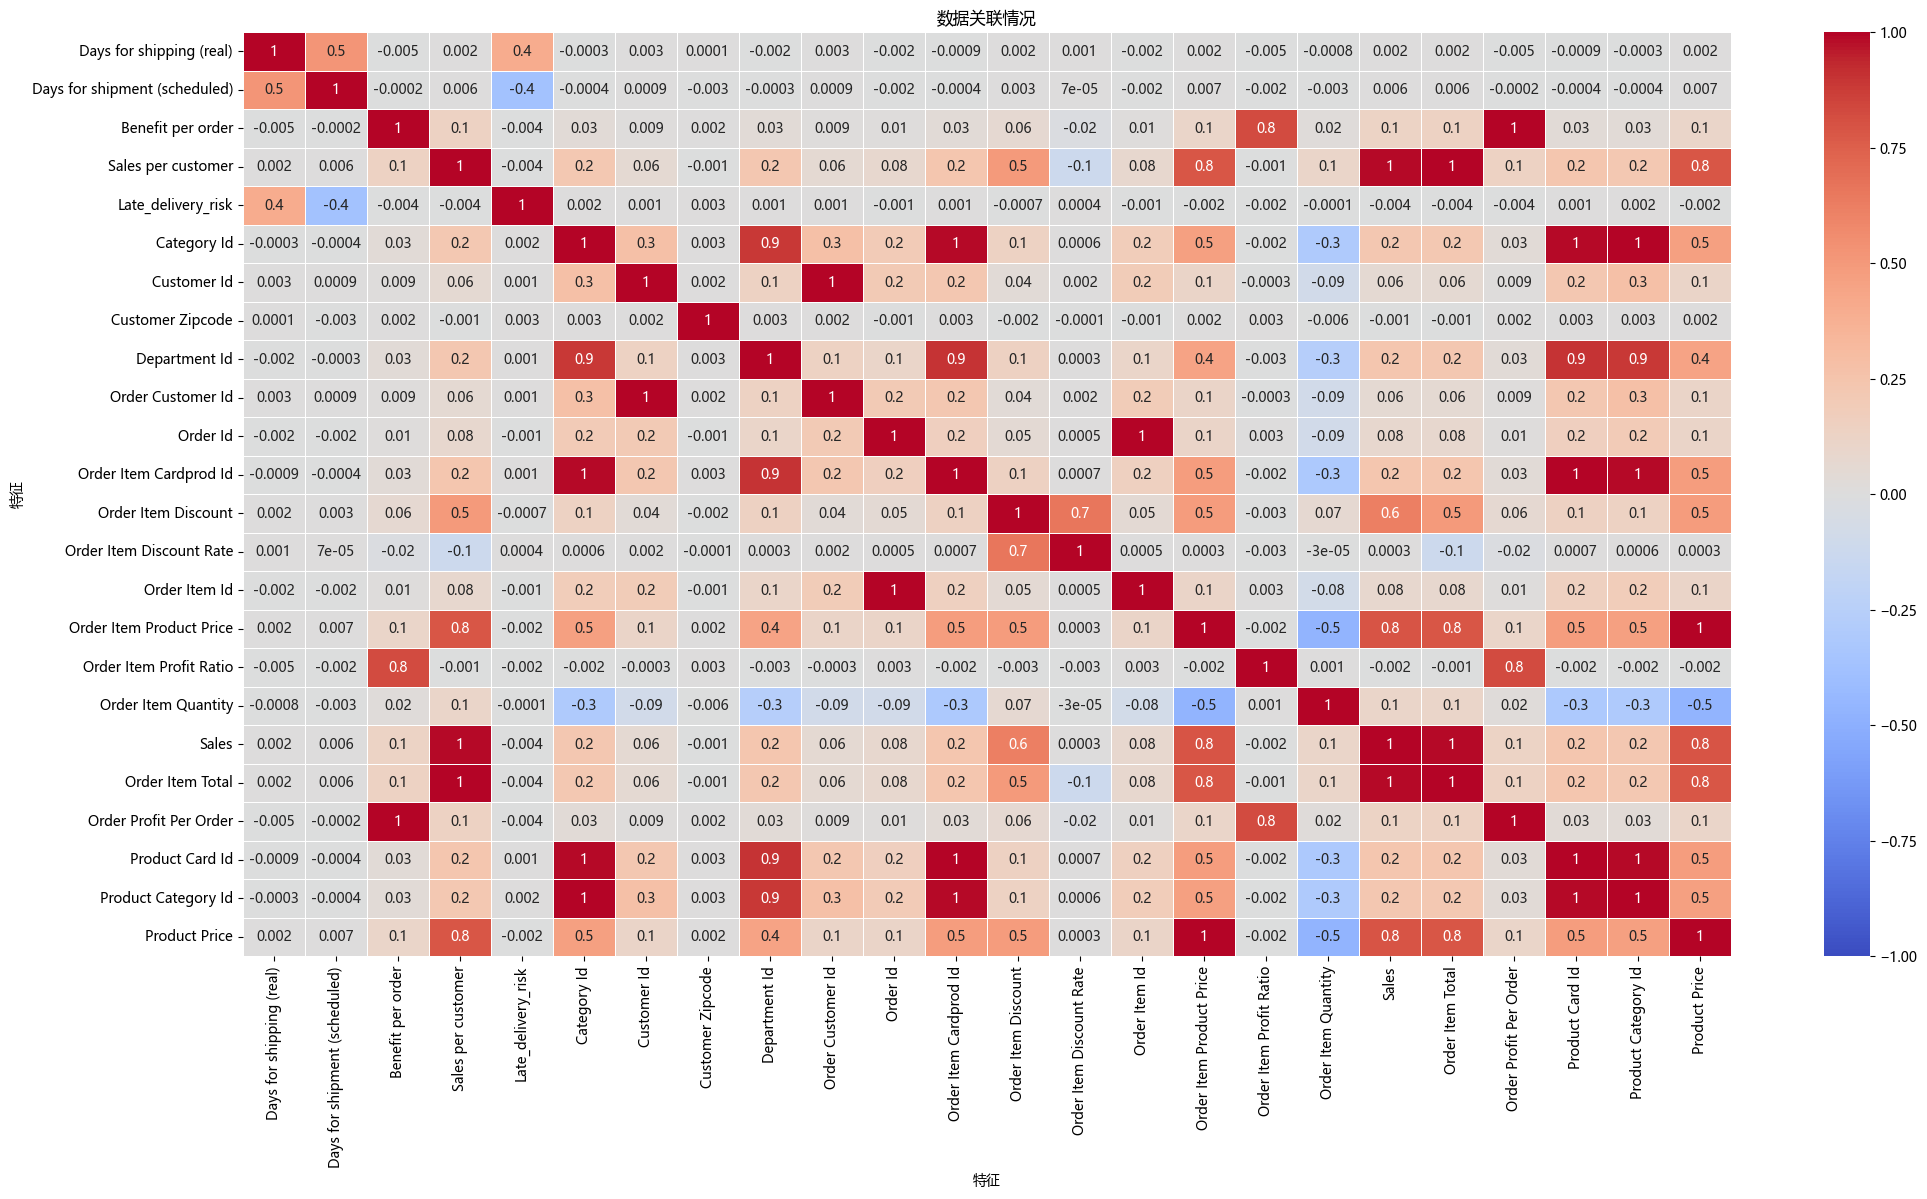

In [10]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
fig, ax = plt.subplots(figsize=(24,12))         
sns.heatmap(data.corr(numeric_only=True),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm', vmin=-1, vmax=1)
ax.set_title('数据关联情况')
ax.set_xlabel('特征')
ax.set_ylabel('特征')

可以观察到产品价格价格与销售额、订单数量具有很高的相关性。

### 分析不同地区的销售额

Text(0.5, 0, '订单地区')

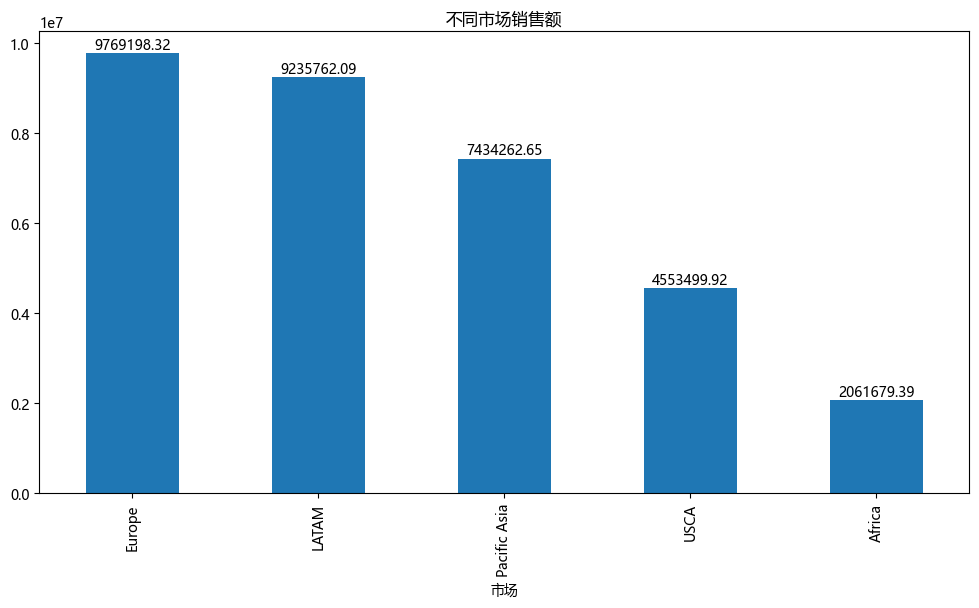

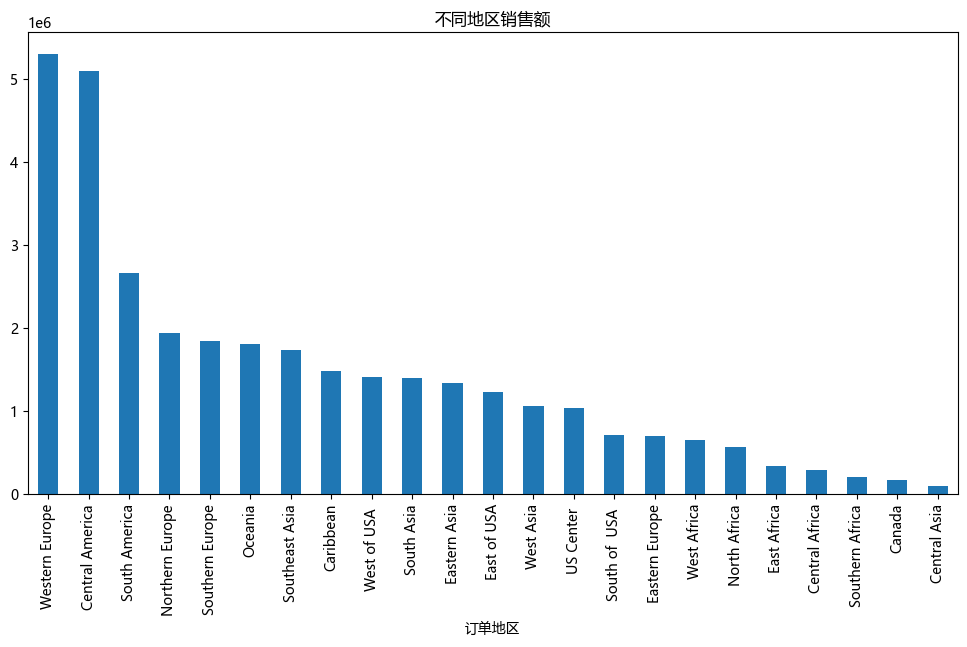

In [11]:
market = data.groupby('Market') 
region = data.groupby('Order Region')
plt.figure(1)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
ax1 =market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="不同市场销售额")
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2, p.get_height(), '{:.2f}'.format(p.get_height()), ha='center', va='bottom')
plt.xlabel('市场')

plt.figure(2)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="不同地区销售额")
plt.xlabel('订单地区')
#fname='C:\\Windows\\Fonts\\msyhl.ttc', name='Microsoft YaHei'

从图中可以看出，欧洲市场的销量最多，而非洲市场的销量最少。在这些市场中，西欧地区和中美洲的销量最高。


#### 分析不同产品的销售量

Text(0.5, 0, '产品类别')

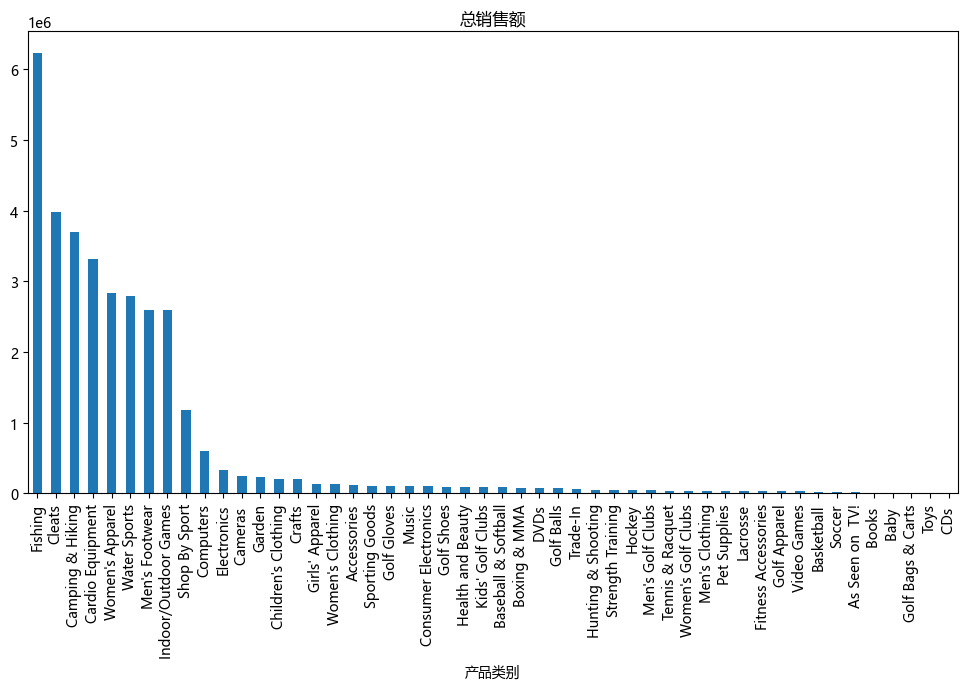

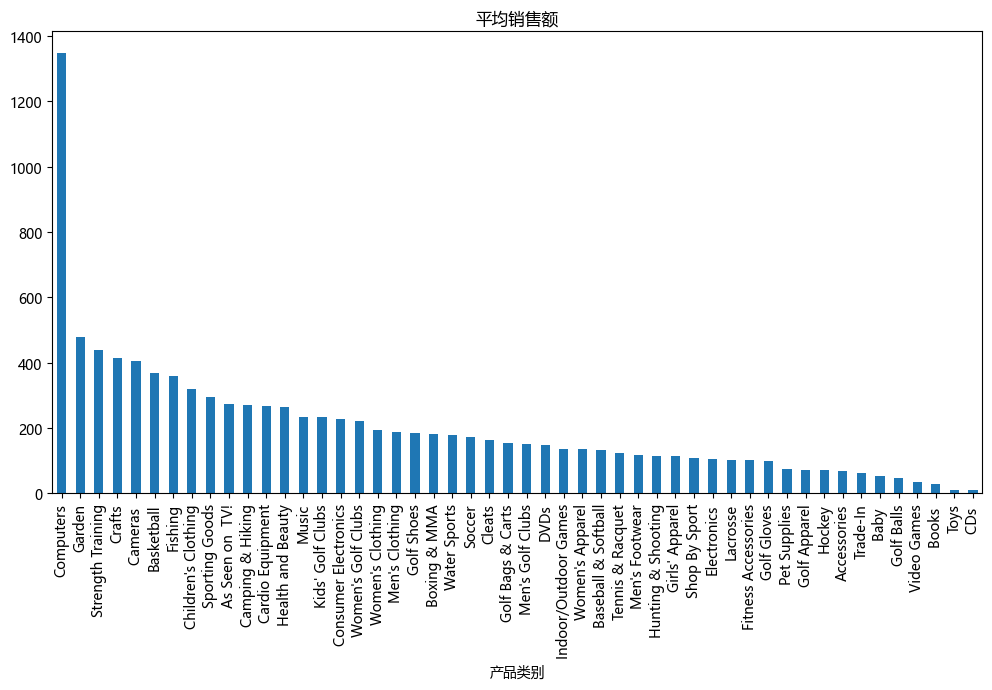

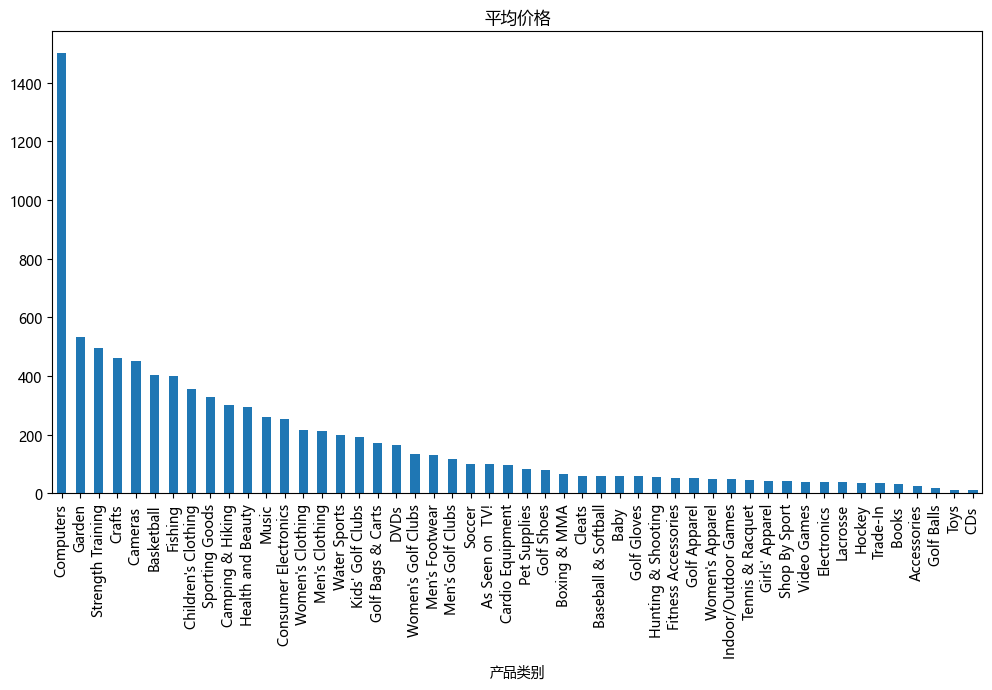

In [12]:
cat = data.groupby('Category Name')
plt.figure(1)
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="总销售额")
plt.xlabel('产品类别')

plt.figure(2)
cat['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="平均销售额")
plt.xlabel('产品类别')

plt.figure(3)
cat['Product Price'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="平均价格")
plt.xlabel('产品类别')

可以看出钓鱼品类的销量最多，其次是防滑钉。另外，平均价格最高的前 7 个产品是平均销量最高的产品

### 分析销售额在不同时间的趋势

In [13]:
data['order_year']= pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).weekday
data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
data['order_month_year'] = pd.to_datetime(data['order date (DateOrders)']).dt.to_period('M')

Text(0.5, 0, '季度')

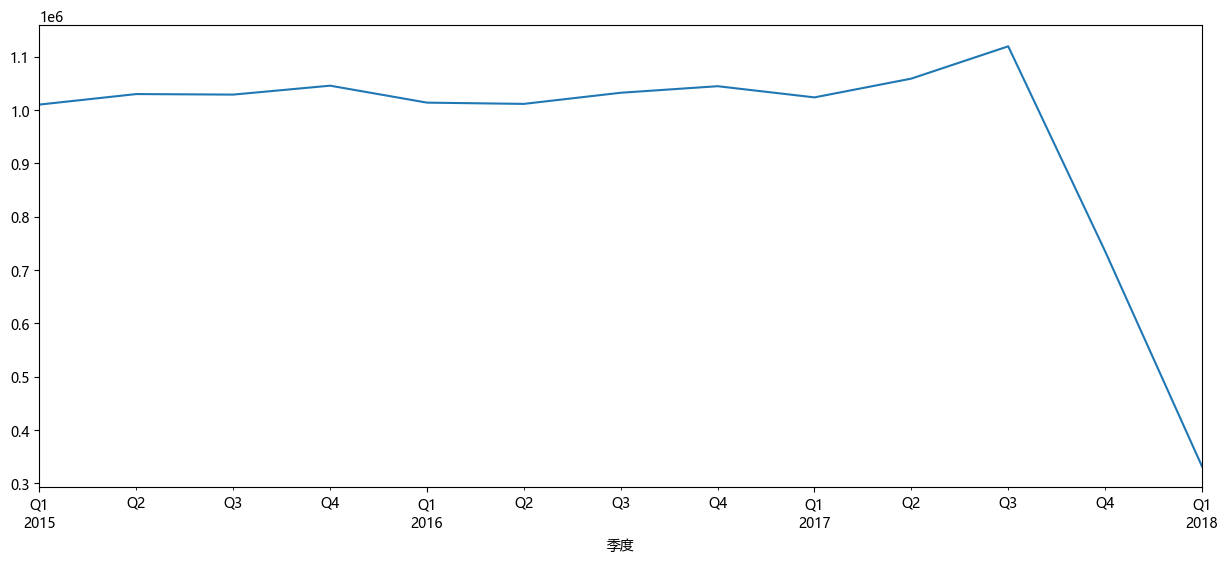

In [14]:
quater= data.groupby('order_month_year')
quartersales=quater['Sales'].sum().resample('Q').mean().plot(figsize=(15,6))
plt.xlabel('季度')

从上图可以看出，从 2015 年第一季度到 2017 年第三季度，销售额保持一致，但到 2018 年第一季度突然下降。

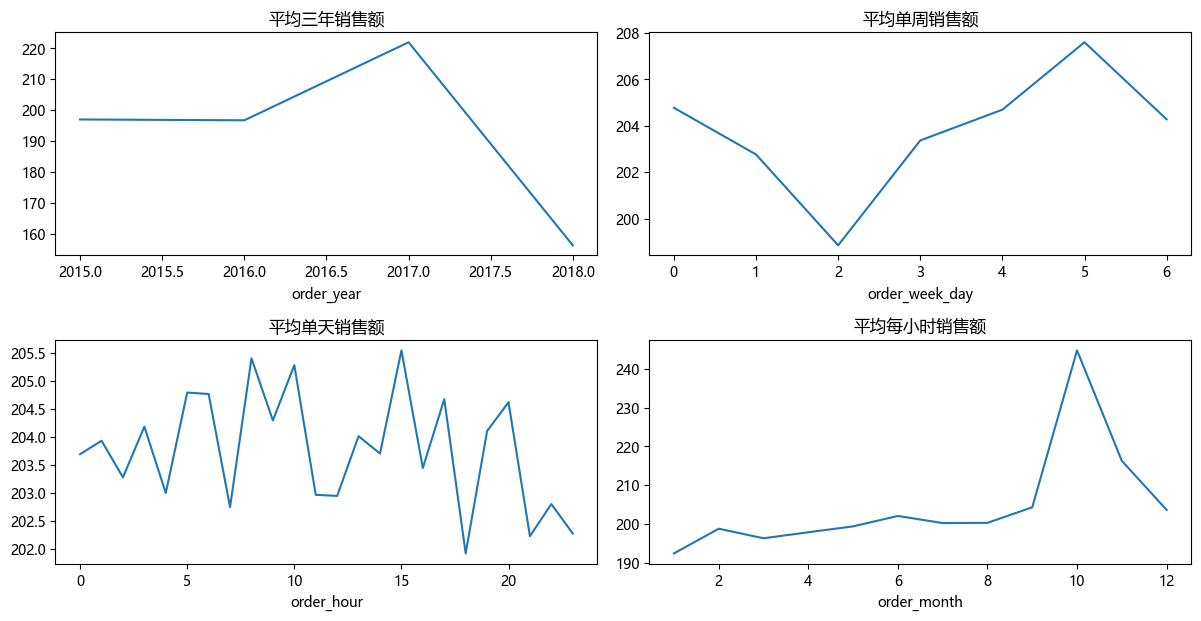

In [15]:
plt.figure(figsize=(10,12))
plt.subplot(4, 2, 1)
quater= data.groupby('order_year')
quater['Sales'].mean().plot(figsize=(12,12),title='平均三年销售额')
plt.subplot(4, 2, 2)
days=data.groupby("order_week_day")
days['Sales'].mean().plot(figsize=(12,12),title='平均单周销售额')
plt.subplot(4, 2, 3)
hrs=data.groupby("order_hour")
hrs['Sales'].mean().plot(figsize=(12,12),title='平均单天销售额')
plt.subplot(4, 2, 4)
mnth=data.groupby("order_month")
mnth['Sales'].mean().plot(figsize=(12,12),title='平均每小时销售额')
plt.tight_layout()
plt.show()

可以看到订单数量最多的月份是 10 月份，其次是 11 月份，所有其他月份的订单数量一致。客户下的订单数量最多的是 2017 年。

### 付款方式分析

In [16]:
data['Type'].unique()

array(['DEBIT', 'TRANSFER', 'CASH', 'PAYMENT'], dtype=object)

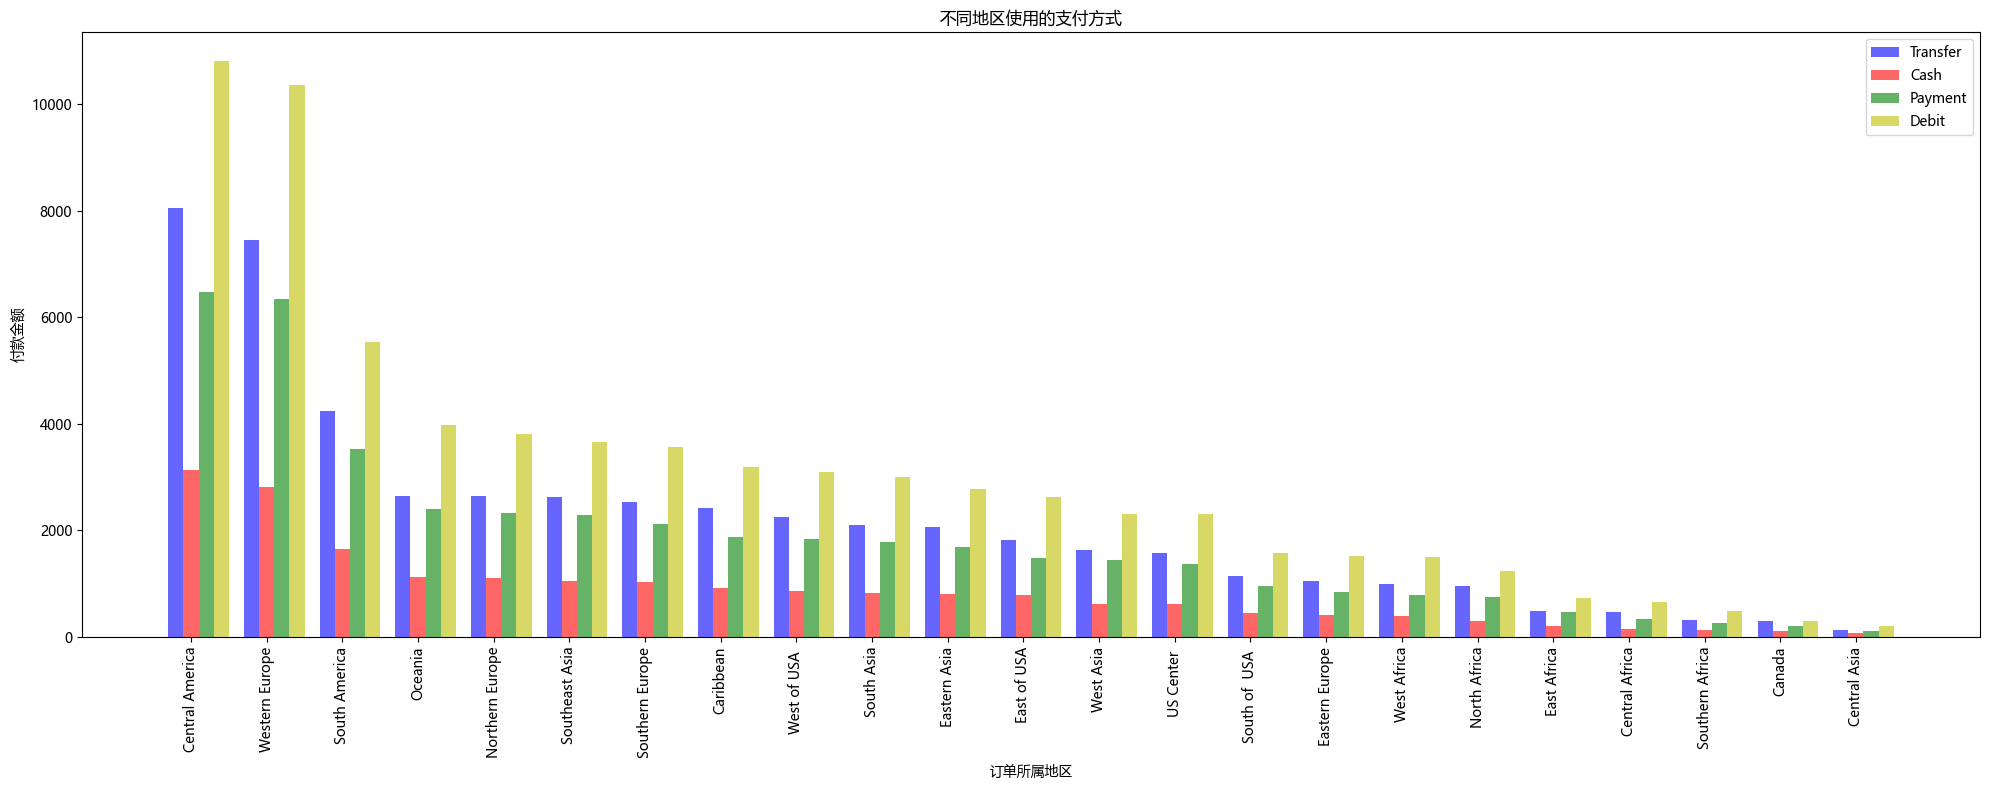

In [17]:
xyz1 = data[(data['Type'] == 'TRANSFER')]
xyz2= data[(data['Type'] == 'CASH')]
xyz3= data[(data['Type'] == 'PAYMENT')]
xyz4= data[(data['Type'] == 'DEBIT')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Transfer')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='Cash')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='Payment')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='Debit')
plt.xlabel('订单所属地区')
plt.ylabel('付款金额')
plt.title('不同地区使用的支付方式')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()


可以看到借记卡是所有地区人们最喜欢的支付方式，现金支付是最不喜欢的方式。

### 亏损分析

总亏损金额是 -3883547.35


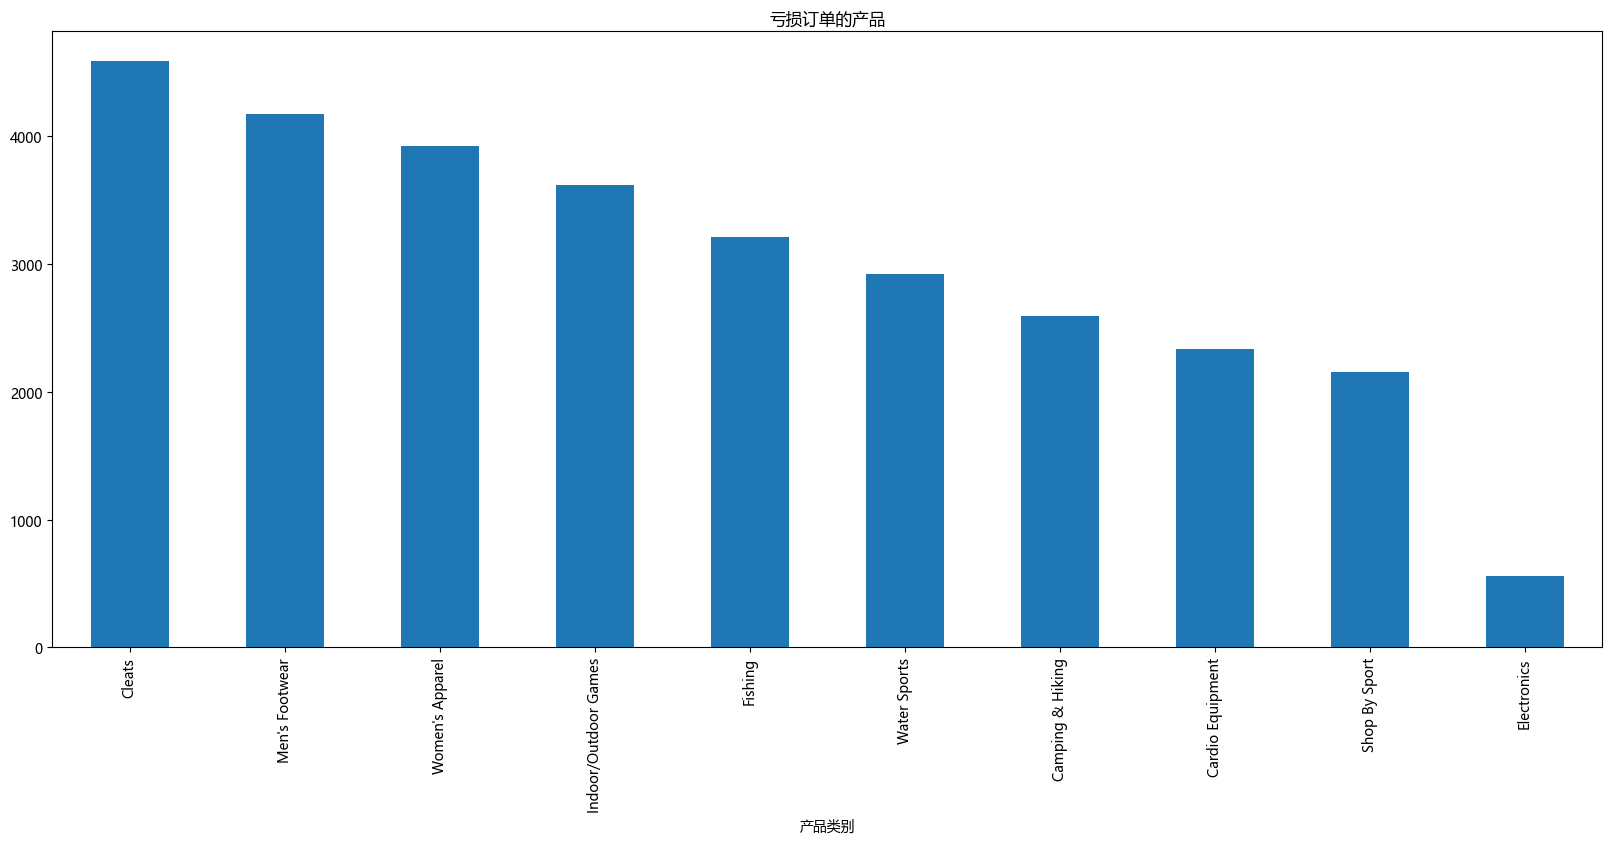

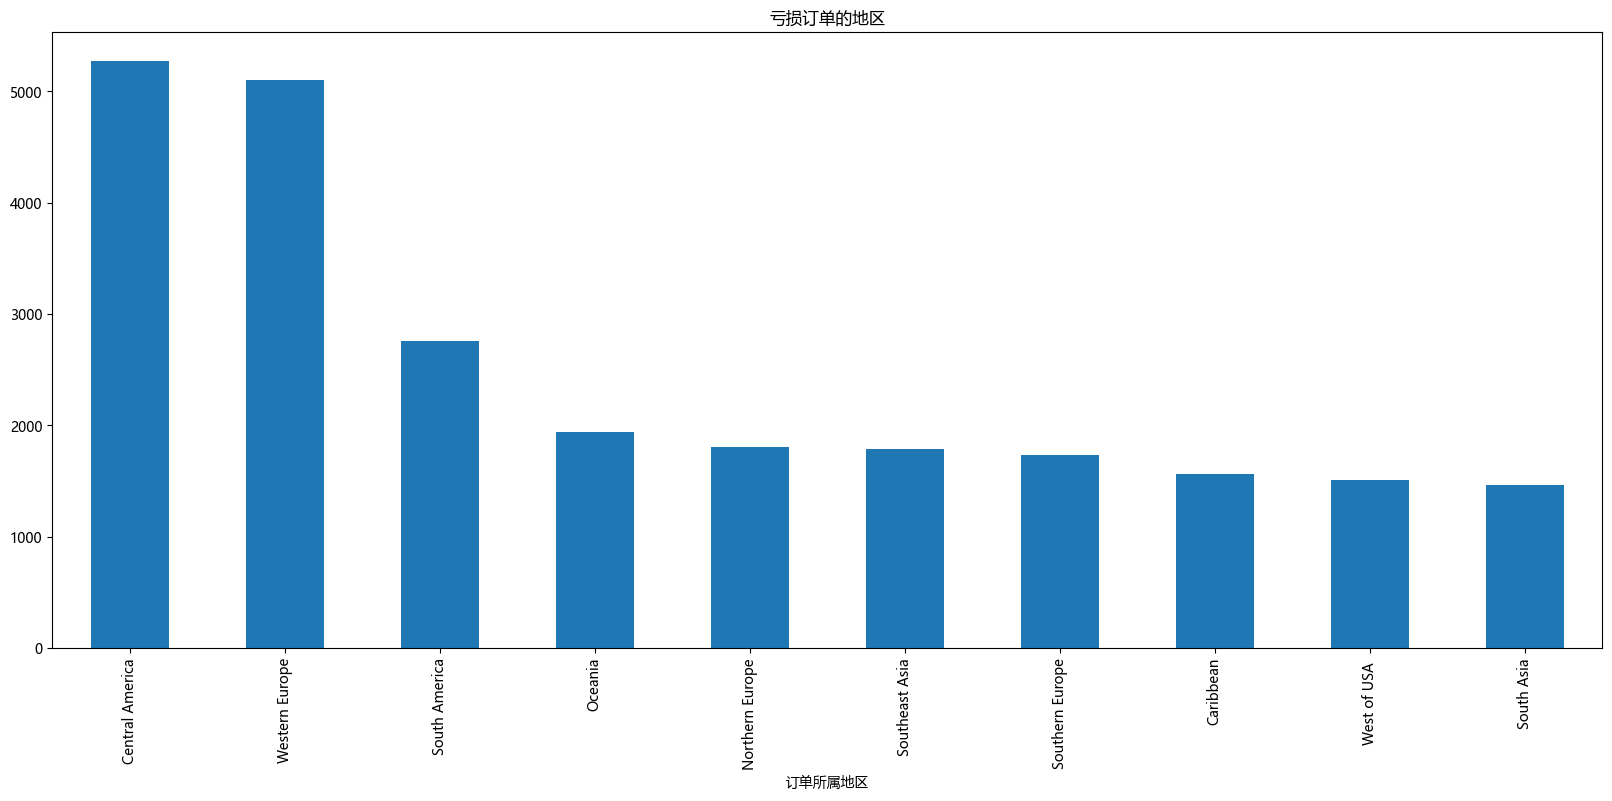

In [18]:
loss = data[(data['Benefit per order']<0)]
plt.figure(1)
loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="亏损订单的产品")
plt.xlabel('产品类别')
plt.figure(2)
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="亏损订单的地区")
plt.xlabel('订单所属地区')
print('总亏损金额是',loss['Benefit per order'].sum().round(2))

可以看到总的亏损销量约为390万，防滑钉是亏损销量最多的品类，其次是男鞋。并且，大部分亏损发生在中美洲和西欧地区。

### 分析亏损的原因

Text(0.5, 0, '运输状态')

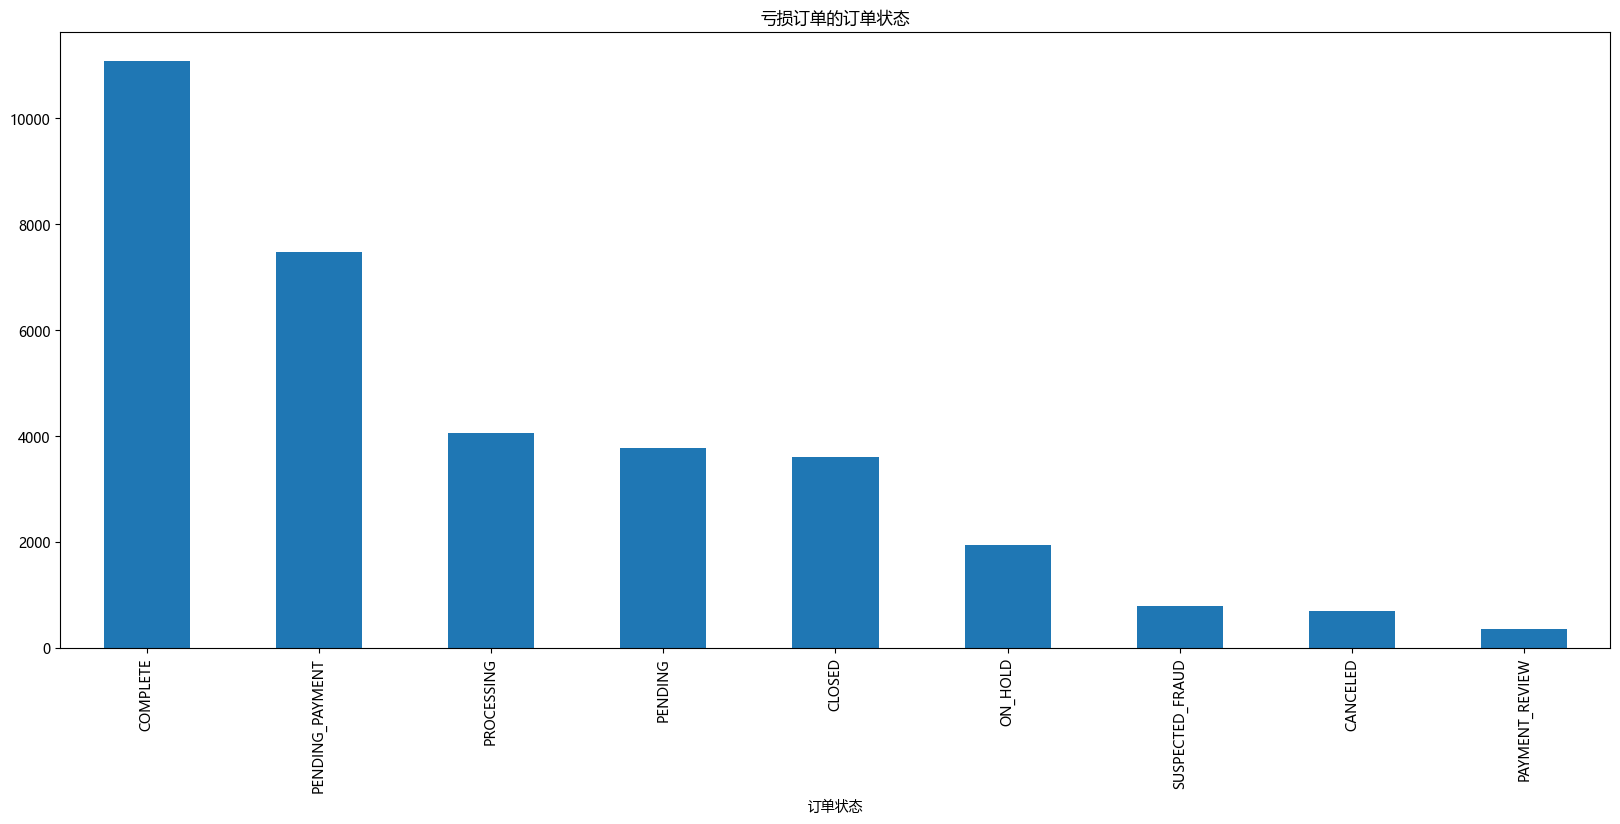

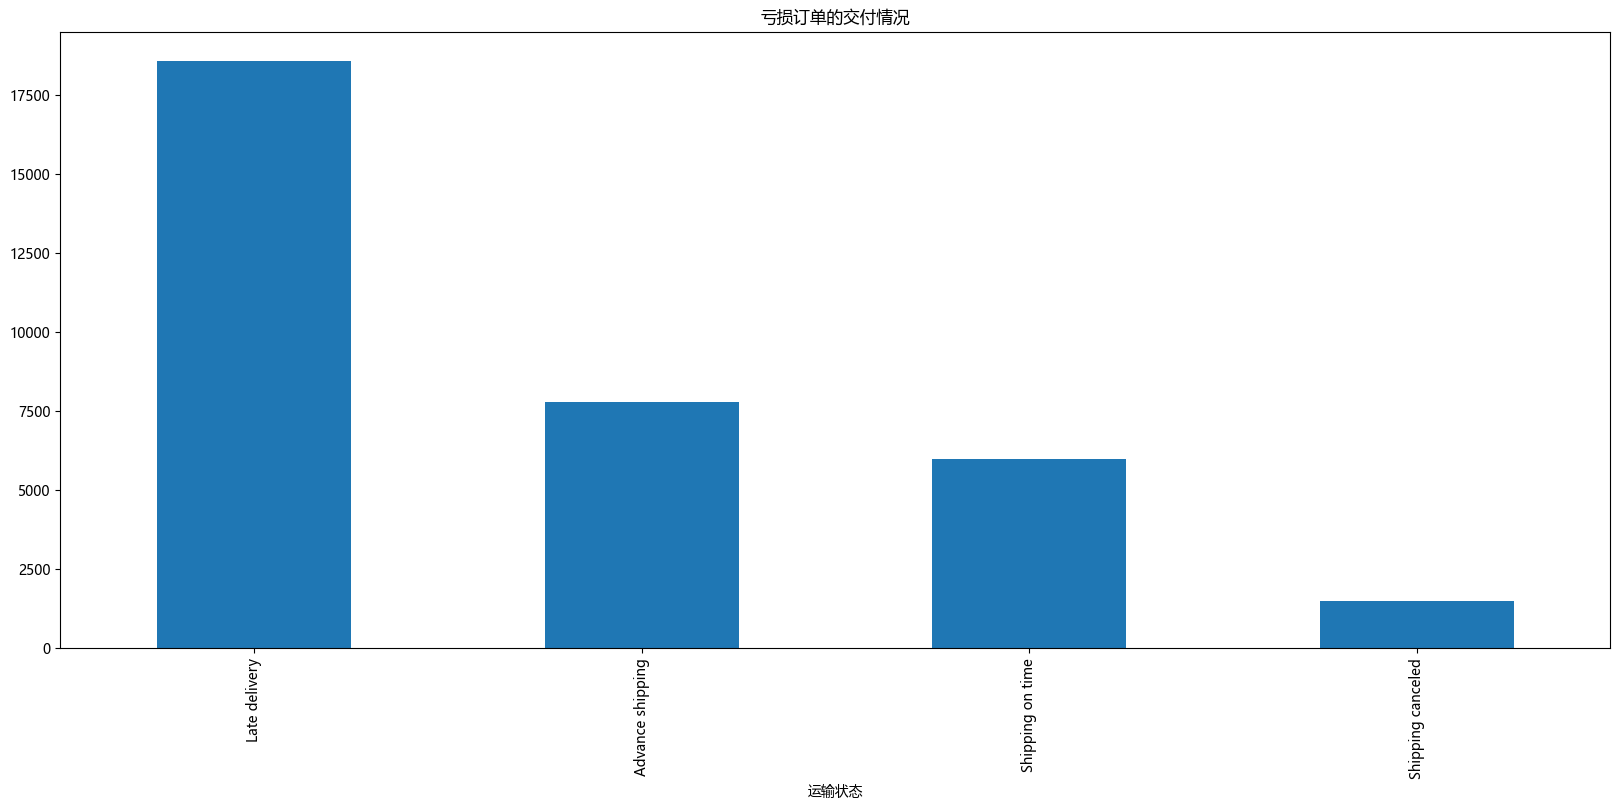

In [19]:
#订单亏损前10的分布情况
plt.figure(1)
loss['Order Status'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="亏损订单的订单状态")
plt.xlabel('订单状态')
plt.figure(2)
loss['Delivery Status'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="亏损订单的交付情况")
plt.xlabel('运输状态')

可以看到亏损很大一部分的原因是因为运输延误造成的，除此之外还存在一小部分的订单欺诈。

Text(0.5, 0, '订单所属地区')

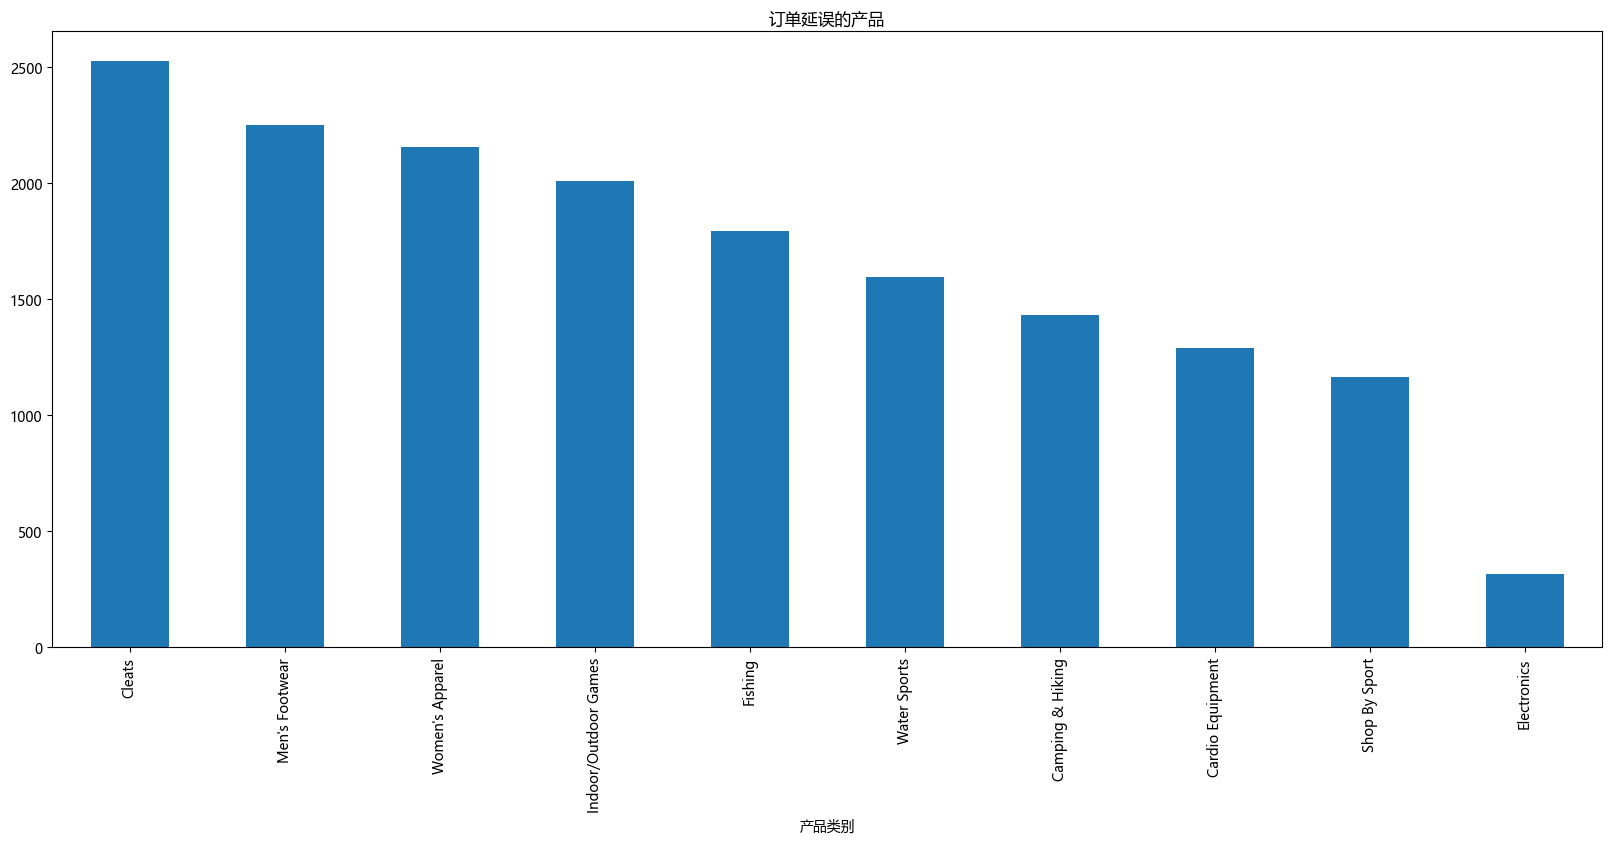

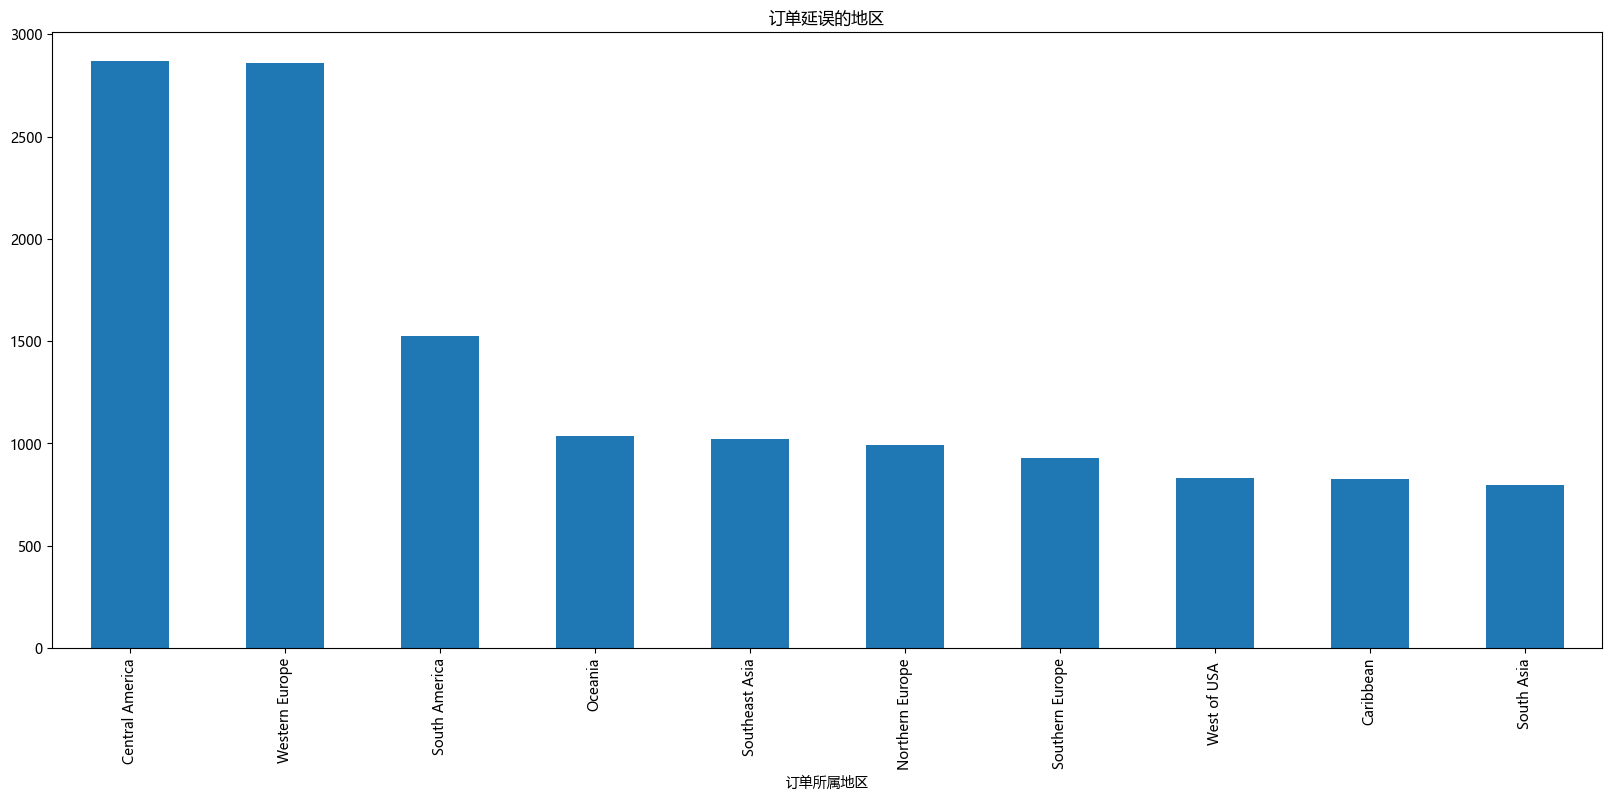

In [20]:
delayloss = data[(data['Benefit per order']<0)&(data['Delivery Status']=='Late delivery')]
plt.figure(1)
delayloss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="订单延误的产品")
plt.xlabel('产品类别')
plt.figure(2)
delayloss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="订单延误的地区")
plt.xlabel('订单所属地区')

可以看到订单延误的产品和地区与亏损情况基本一致。

### 订单欺诈分析

In [21]:
xyz = data[(data['Order Status'] == 'SUSPECTED_FRAUD')]
xyz['Order Region'].value_counts()

Order Region
Western Europe     705
Central America    631
South America      361
West of USA        236
Oceania            229
Southern Europe    223
Caribbean          190
Southeast Asia     187
Northern Europe    170
Eastern Asia       156
East of USA        150
West Asia          147
South Asia         144
US Center          121
North Africa        75
Eastern Europe      74
West Africa         71
South of  USA       66
Southern Africa     32
East Africa         31
Canada              29
Central Africa      28
Central Asia         6
Name: count, dtype: int64

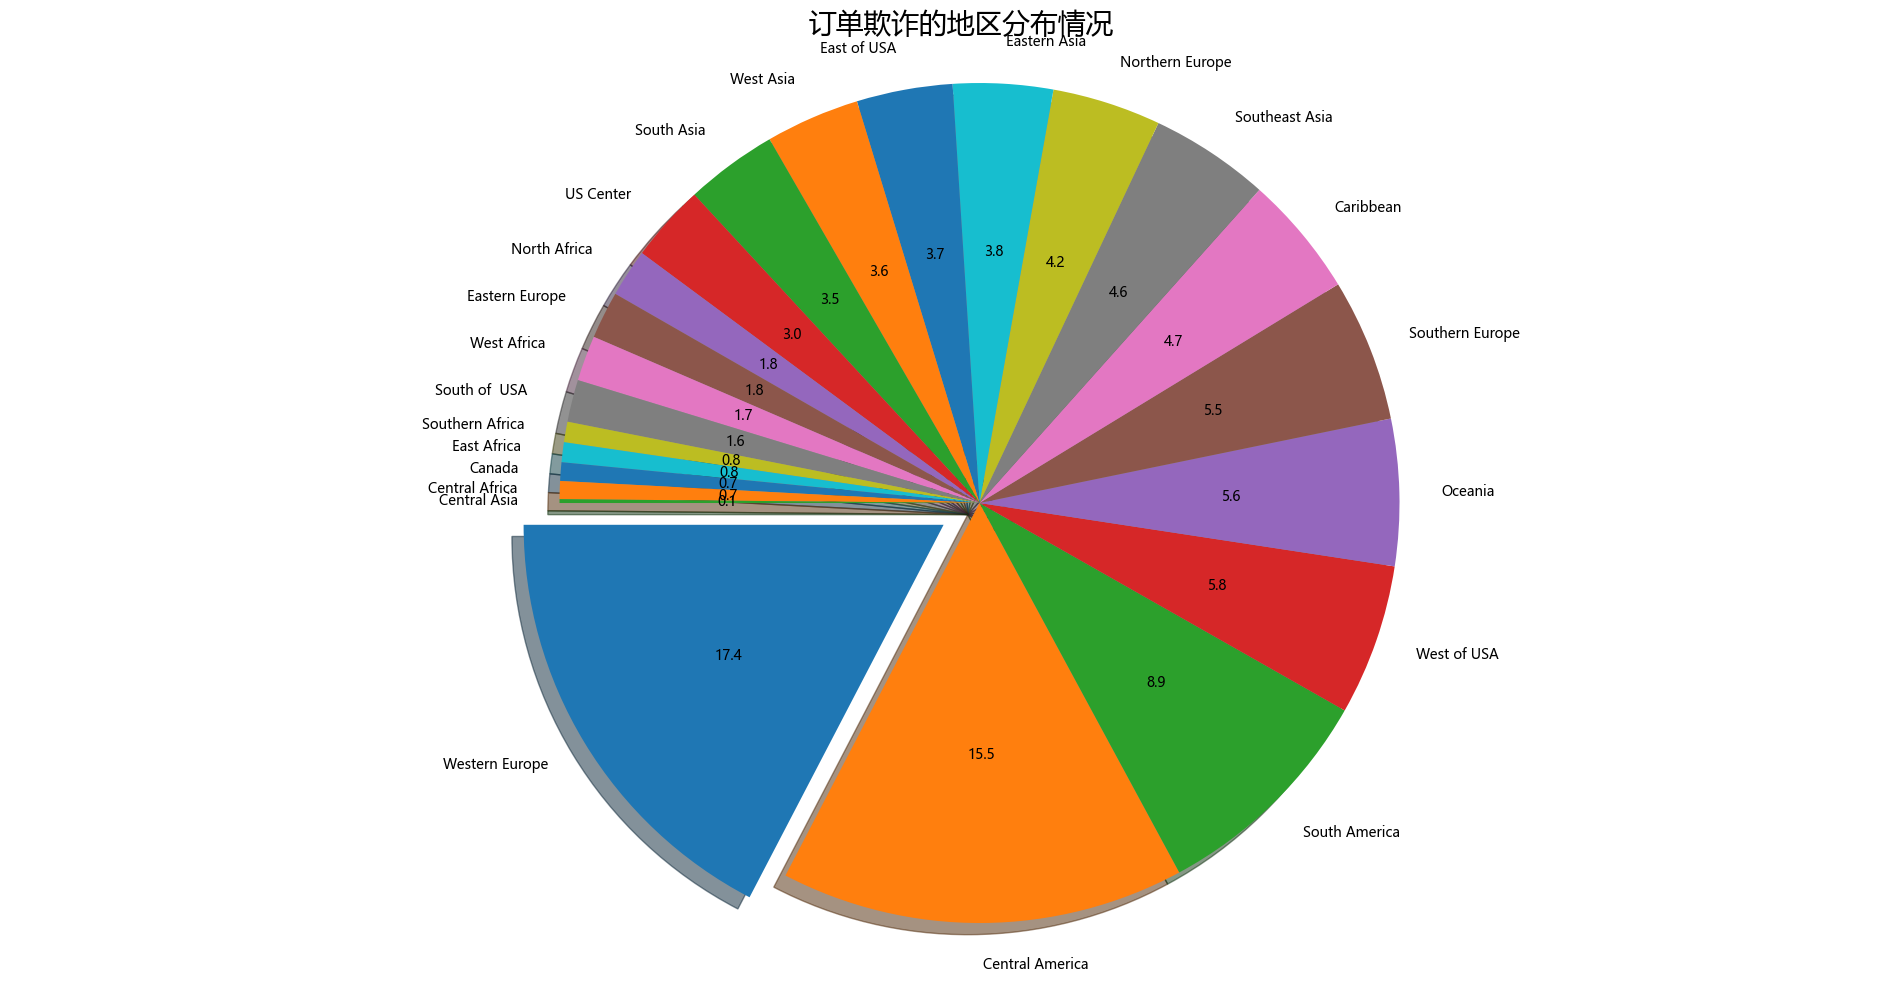

In [22]:
# 筛选出订单状态为SUSPECTED_FRAUD的数据，即疑似欺诈的订单
high_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') ]

fraud=high_fraud['Order Region'].value_counts().plot.pie(figsize=(24,12),
                                                  startangle=180, explode=(0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),autopct='%.1f',shadow=True,)

plt.title("订单欺诈的地区分布情况",size=20) 

plt.ylabel(" ")

fraud.axis('equal') 

plt.show()


可以看出，疑似欺诈订单数量最多的是西欧，约占订单总数的 17.4%，其次是中美洲，占 15.5%。 

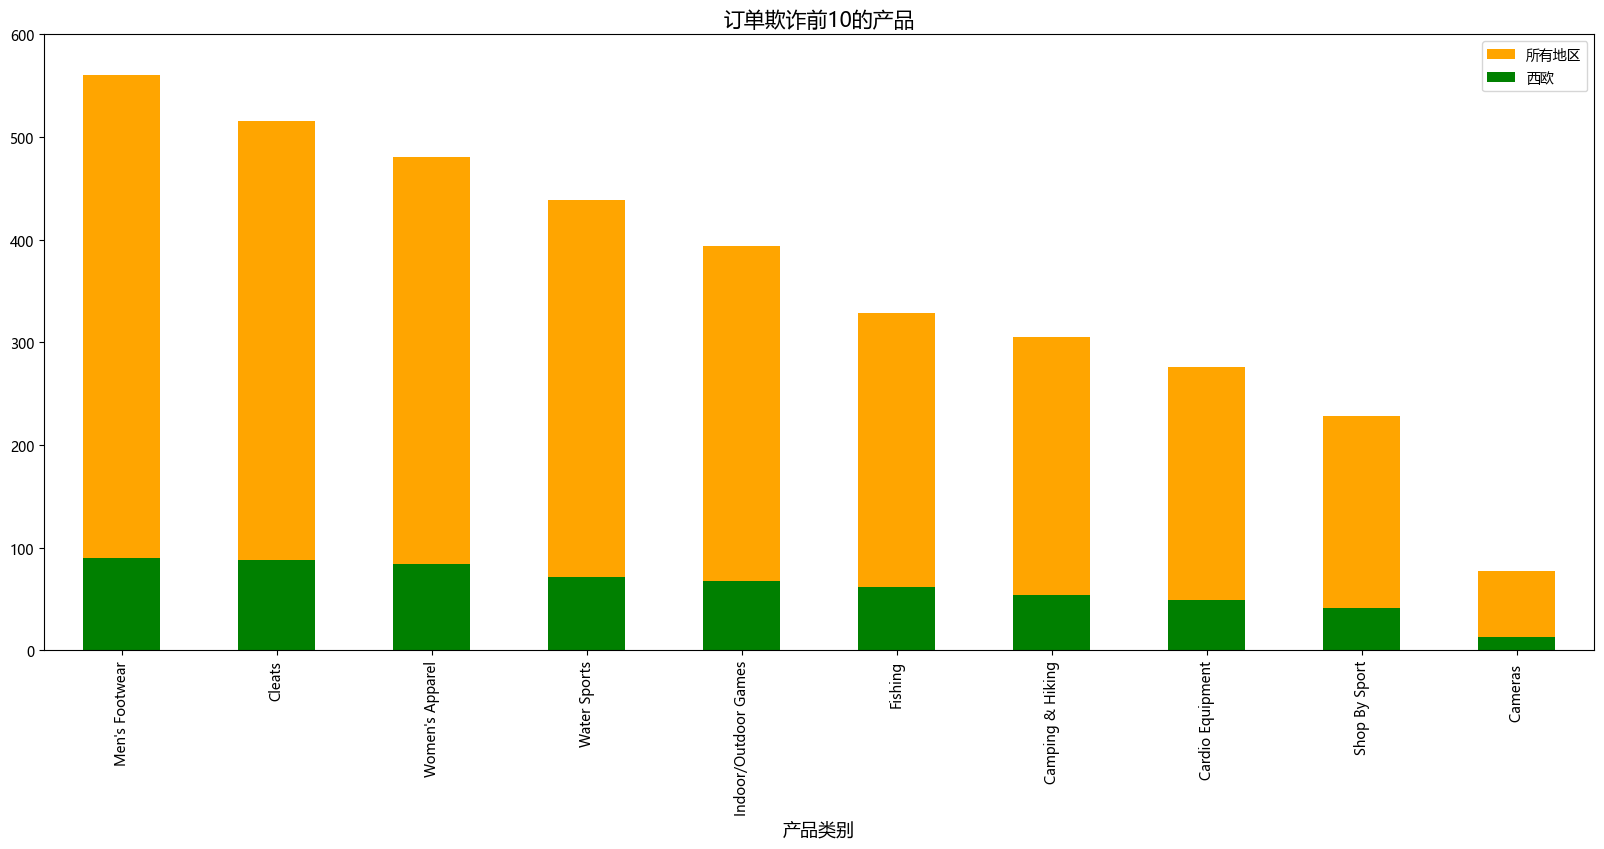

In [23]:
# 筛选出订单状态为SUSPECTED_FRAUD的数据，即疑似欺诈的订单
high_fraud1 = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] 
# 筛选出订单状态为SUSPECTED_FRAUD并且订单地区为西欧的数据，即西欧地区的疑似欺诈订单
high_fraud2 = data[(data['Order Status'] == 'SUSPECTED_FRAUD') &(data['Order Region'] == 'Western Europe')]
# 统计所有地区的疑似欺诈订单中每个产品类别的数量，并按照降序排序，取出前10名
fraud1=high_fraud1['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud Category",color='orange')

fraud2=high_fraud2['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud product in Western Europe",color='green')

plt.legend(["所有地区", "西欧"])

plt.title("订单欺诈前10的产品", size=15)

plt.xlabel("产品类别", size=13)

plt.ylim(0,600)

plt.show()


可以看到在所有地区以及西欧，鞋类欺诈订单最多。

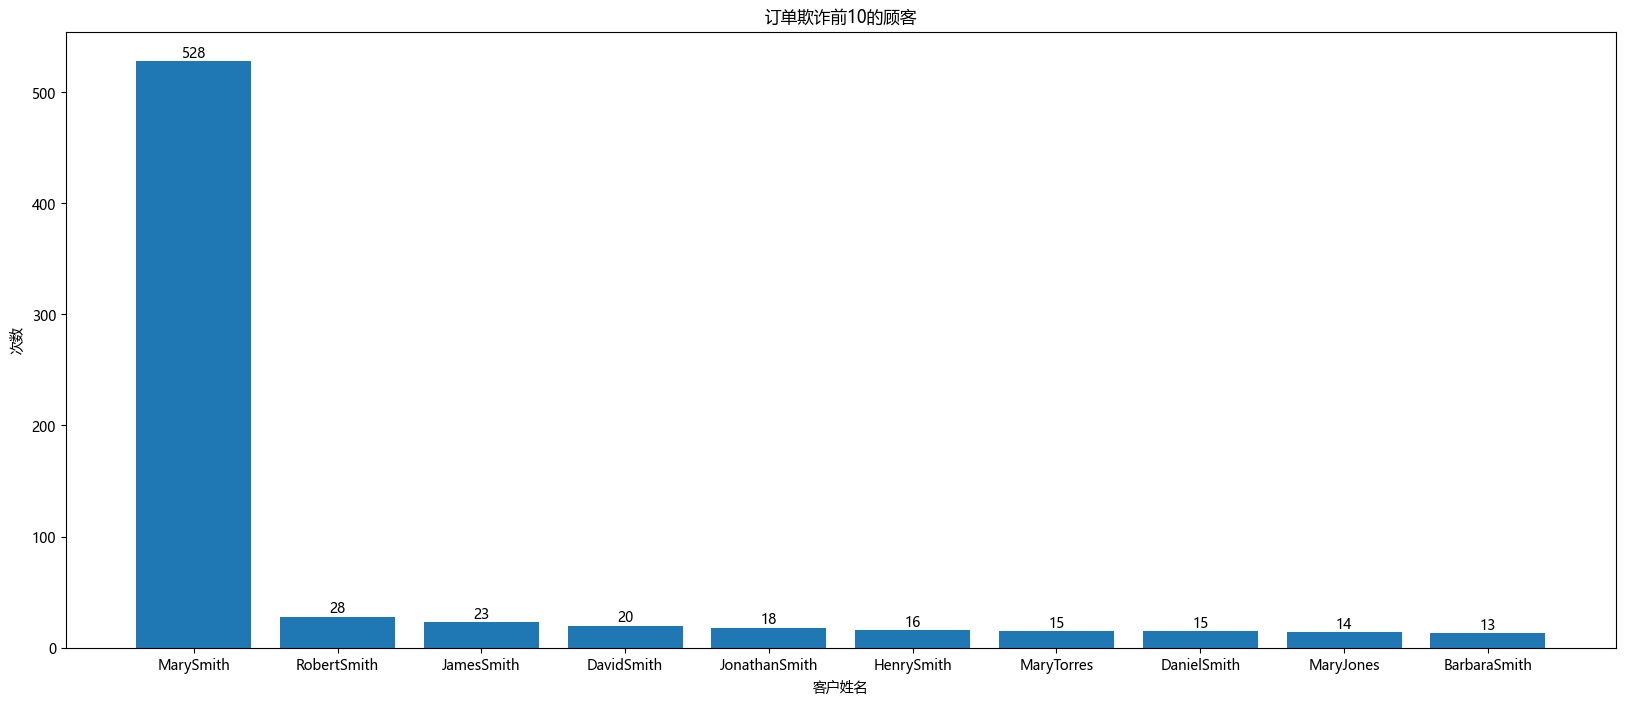

In [24]:
# 筛选出订单状态为SUSPECTED_FRAUD的数据，即疑似欺诈的订单
cus = data[(data['Order Status'] == 'SUSPECTED_FRAUD')]
# 统计每个顾客的疑似欺诈订单的数量，并按照降序排序，取出前10名
top_10_customers = cus['Customer Full Name'].value_counts().nlargest(10)

fig, ax = plt.subplots(figsize=(20, 8))

ax.bar(top_10_customers.index, top_10_customers.values)

for i in range(len(top_10_customers)):
    ax.annotate(f"{top_10_customers.values[i]}", (top_10_customers.index[i], top_10_customers.values[i]), ha="center", va="bottom")

ax.set_title("订单欺诈前10的顾客")

plt.xlabel('客户姓名')
plt.ylabel('次数')
plt.show()


可以看到这位名叫Mary Smith的客户责试图进行欺诈528次！

In [25]:
amount = data[(data['Customer Full Name'] == 'MarySmith')&(data['Order Status'] == 'SUSPECTED_FRAUD')]

amount['Sales'].sum().round(2)

102491.66

可以看到总金额超过10.2W。

### 交付情况分析

Text(0.5, 0, '产品类别')

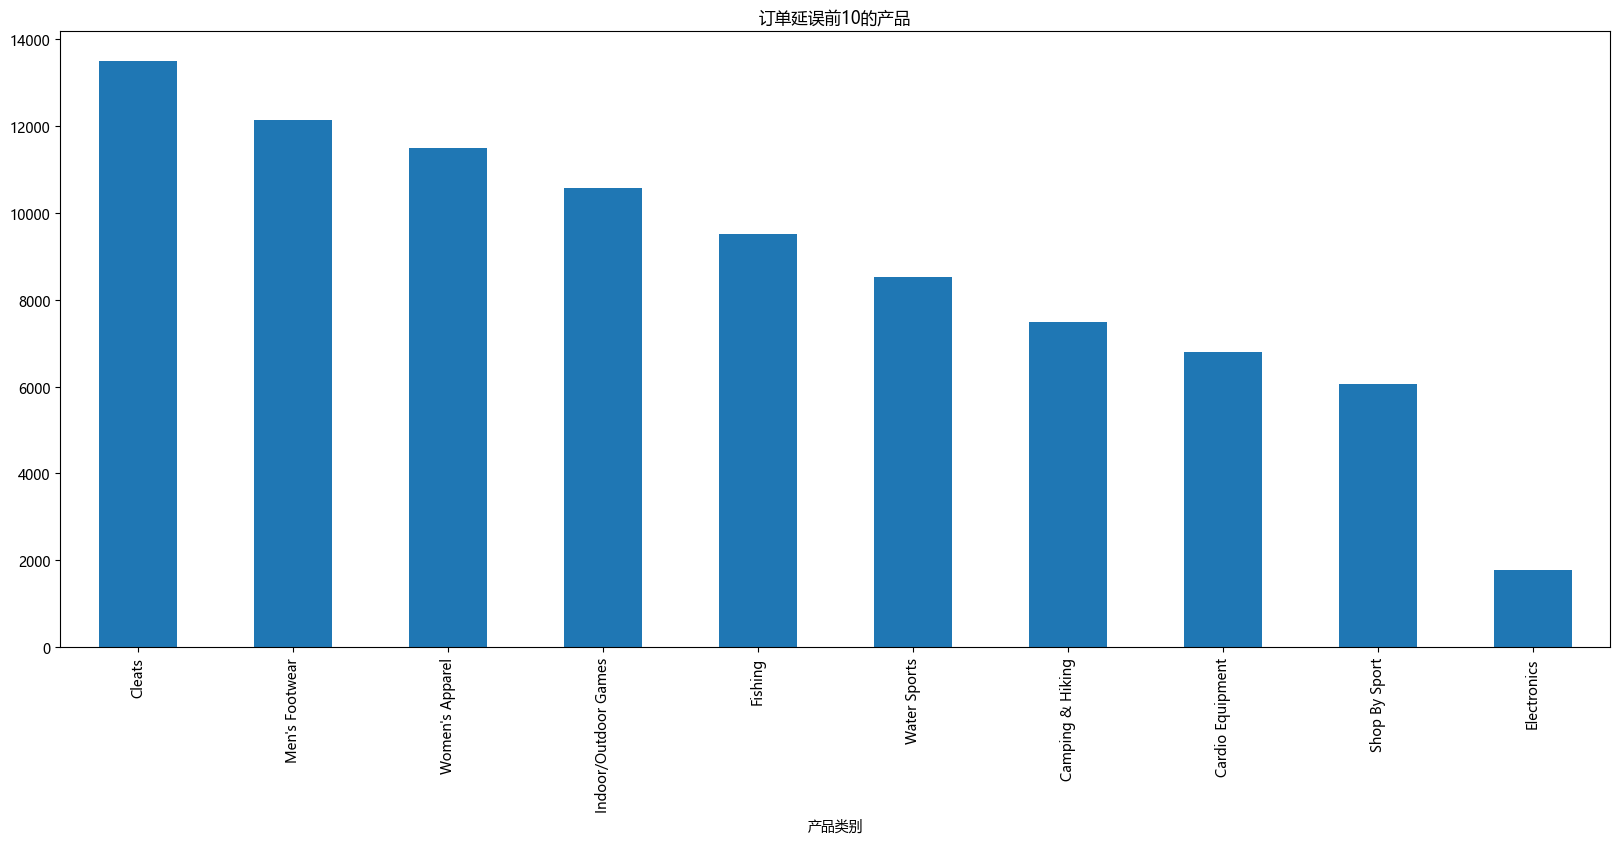

In [26]:
late_delivery = data[(data['Delivery Status'] == 'Late delivery')]
late_delivery['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="订单延误前10的产品")
plt.xlabel('产品类别')

可以看出，防滑钉的订单延迟最多，其次是男鞋。对于部分订单，数据中给出了延迟交货的风险。将具有延迟交货风险的产品与延迟交货的产品进行比较。

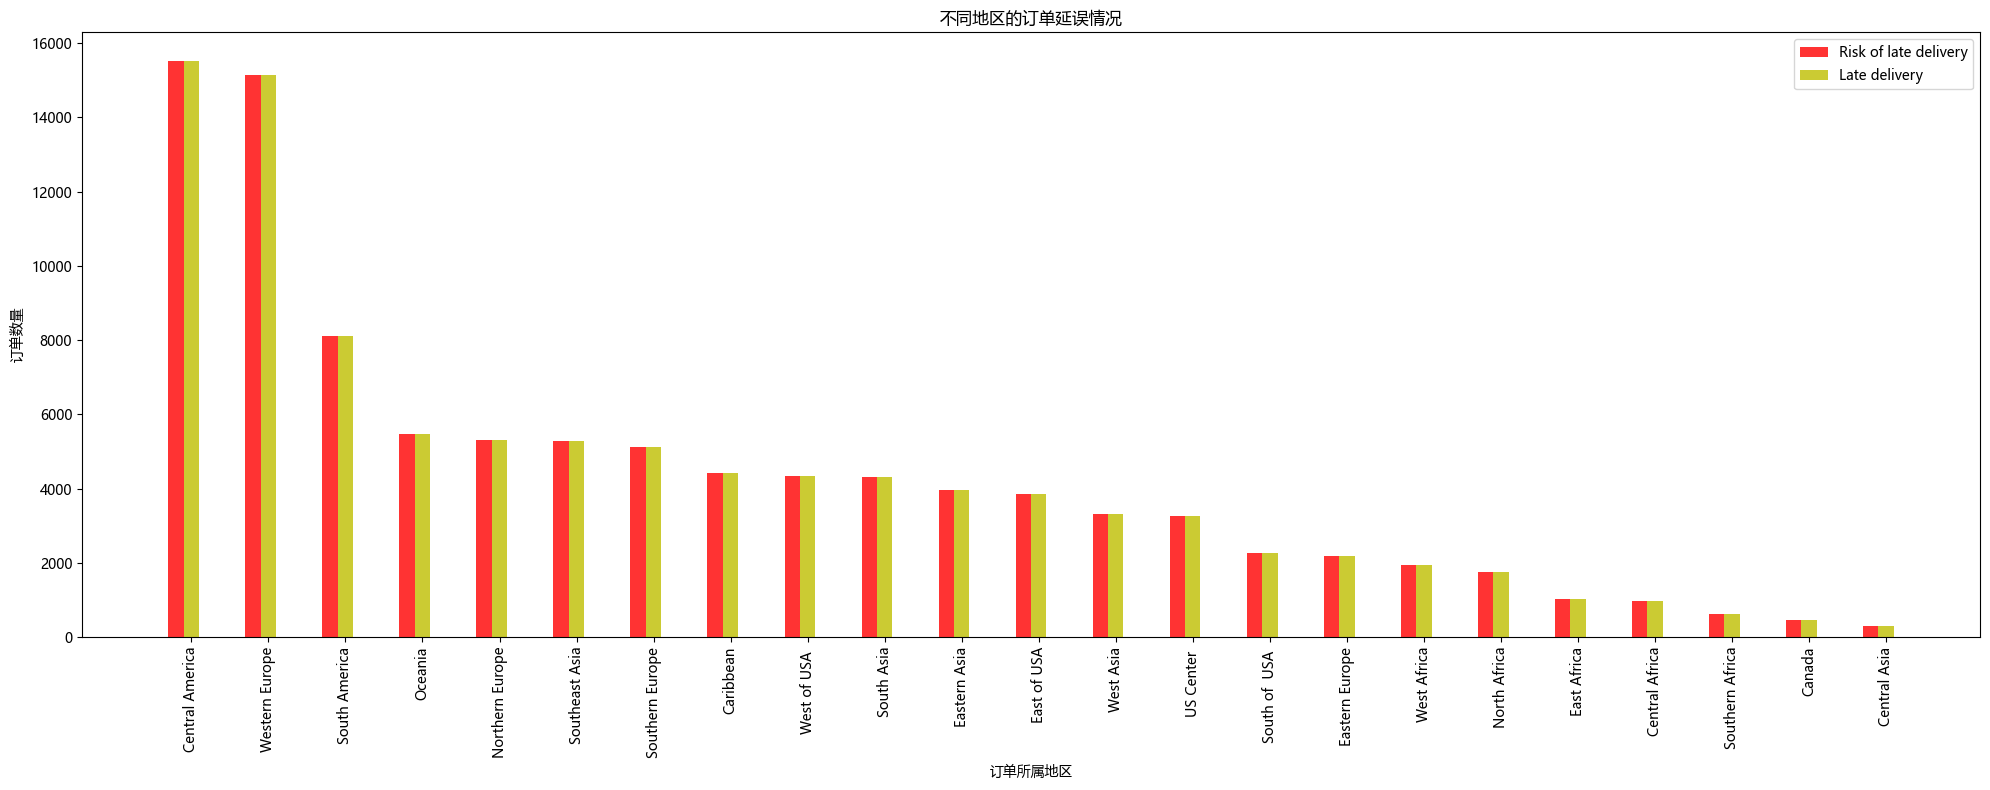

In [27]:
# 筛选出有延误风险的订单，即Late_delivery_risk为1的订单
xyz1 = data[(data['Late_delivery_risk'] == 1)]
# 筛选出实际延误的订单，即Delivery Status为Late delivery的订单
xyz2 = data[(data['Delivery Status'] == 'Late delivery')]
# 统计每个地区有延误风险的订单的数量
count1=xyz1['Order Region'].value_counts()
# 统计每个地区实际延误的订单的数量
count2=xyz2['Order Region'].value_counts()
# 获取所有地区的名称
names=data['Order Region'].value_counts().keys()

n_groups=23
fig,ax = plt.subplots(figsize=(20,8)) 
index=np.arange(n_groups)
bar_width=0.2
opacity=0.8

type1=plt.bar(index,count1,bar_width,alpha=opacity,color='r',label='Risk of late delivery')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='y',label='Late delivery')

plt.xlabel('订单所属地区')
plt.ylabel('订单数量')
plt.title('不同地区的订单延误情况')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

因此，可以得出结论，对于所有具有延迟交货风险的产品，无论在哪个地区，产品实际上都在延迟交货。另外，对所有地区不同类型运输方式的延迟交付订单数量分析。

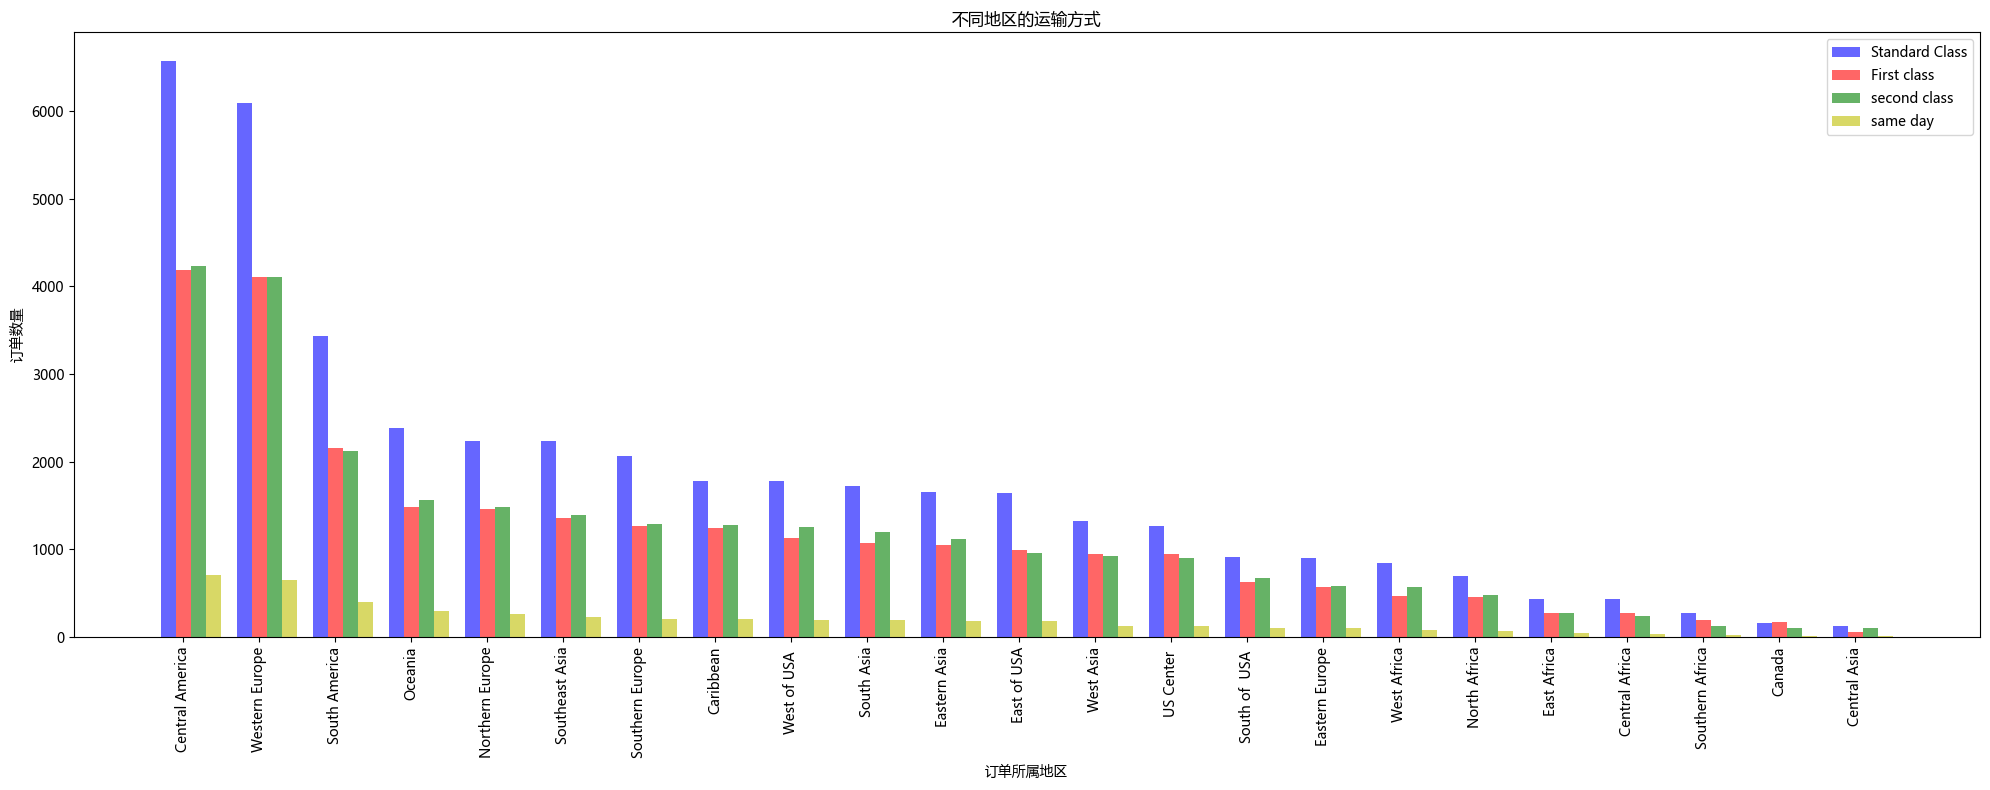

In [28]:
# 筛选出实际延误并且运输方式为Standard Class的订单
xyz1 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Standard Class')]
# 筛选出实际延误并且运输方式为First Class的订单
xyz2 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'First Class')]
# 筛选出实际延误并且运输方式为Second Class的订单
xyz3 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Second Class')]
# 筛选出实际延误并且运输方式为Same Day的订单
xyz4 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Same Day')]
# 统计每个地区实际延误并且运输方式为Standard Class的订单的数量
count1=xyz1['Order Region'].value_counts()
# 统计每个地区实际延误并且运输方式为First Class的订单的数量
count2=xyz2['Order Region'].value_counts()
# 统计每个地区实际延误并且运输方式为Second Class的订单的数量
count3=xyz3['Order Region'].value_counts()
# 统计每个地区实际延误并且运输方式为Same Day的订单的数量
count4=xyz4['Order Region'].value_counts()
# 获取所有地区的名称
names=data['Order Region'].value_counts().keys()

n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6

type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Standard Class')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='First class')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='second class')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='same day')

plt.xlabel('订单所属地区')
plt.ylabel('订单数量')
plt.title('不同地区的运输方式')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

正如预期的那样，所有地区的延误交货数量最多的是标准舱运输，当天运输是延误交货数量最少的运输。一等舱和二舱运输的延误交货数量几乎相同。

# 客户细分

了解客户需求并根据他们的需求针对特定客户群是供应链公司增加客户数量并获得更多利润的一种方式。由于数据集中已经提供了客户的购买历史记录，因此可以使用RFM模型。

In [29]:
#消费总金额
data['TotalPrice'] = data['Order Item Quantity'] * data['Order Item Product Price']

In [30]:
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])
data['order date (DateOrders)'].max() # 最后下单时间

Timestamp('2018-01-31 23:38:00')

数据集中的最后一个订单是在 2018 年 1 月 31 日下的。 因此，当前时间设置为最后下单日期的另一天，以获得更准确的新近度值。

In [31]:
present = dt.datetime(2018,2,1)
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])

In [32]:
# 按照顾客ID分组数据，并对每个分组计算以下三个指标：
# R_Value：最近一次消费距离当前日期的天数，使用order date (DateOrders)列中的最大值和present变量相减得到
# F_Value：消费频率，即订单数量，使用Order Id列中的元素个数得到
# M_Value：消费金额，即总价，使用TotalPrice列中的元素和得到
Customer_seg = data.groupby('Order Customer Id').agg({'order date (DateOrders)': lambda x: (present - x.max()).days, 'Order Id': lambda x: len(x), 'TotalPrice': lambda x: x.sum()})

Customer_seg['order date (DateOrders)'] = Customer_seg['order date (DateOrders)'].astype(int)

Customer_seg.rename(columns={'order date (DateOrders)': 'R_Value', 
                         'Order Id': 'F_Value', 
                         'TotalPrice': 'M_Value'}, inplace=True)

Customer_seg.head()


,R_Value,F_Value,M_Value
Order Customer Id,,,
1,792,1,499.949989
2,136,10,1819.730042
3,229,18,3537.680090
4,380,14,1719.630032
5,457,7,1274.750034


R_Value（时间）表示自客户上次下单以来经过的时间。

F_Value（频率）表示顾客订购的次数。

M_Value（消费金额）告诉我们客户购买商品花费了多少钱。

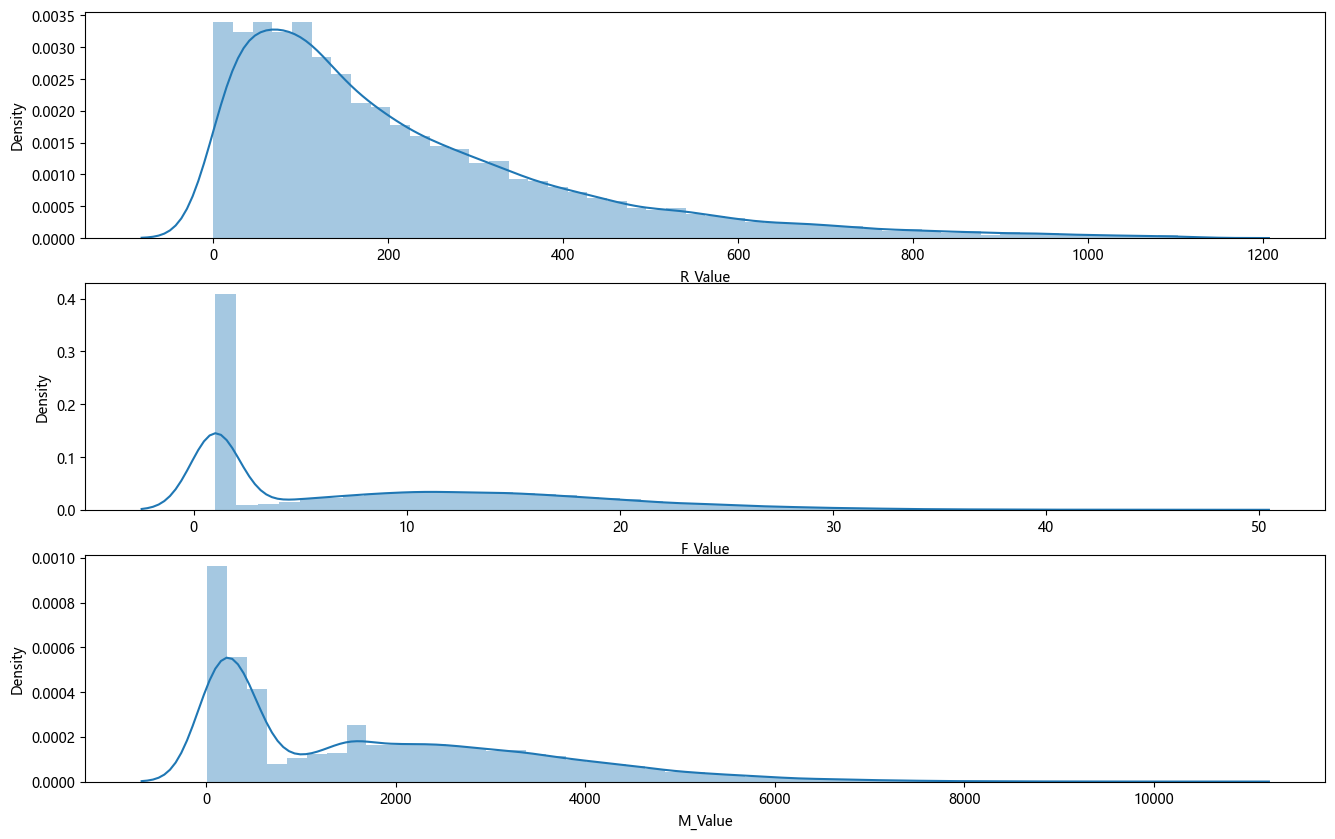

In [33]:
plt.figure(figsize=(16,10)) 
plt.subplot(3, 1, 1)
sns.distplot(Customer_seg['R_Value'])
plt.subplot(3, 1, 2) 
sns.distplot(Customer_seg['F_Value'])
plt.subplot(3, 1, 3)
sns.distplot(Customer_seg['M_Value'])
plt.show()

In [34]:
quantiles = Customer_seg.quantile(q=[0.25,0.5,0.75]) 
quantiles = quantiles.to_dict() 

总数据分为 4 个分位数。 R_Value 应较低，因为它表示最近的客户活动，而 F_value、M_Value 应较高，因为它们表示购买频率和总价值。

In [35]:
#R值越低越好
def R_Score(a,b,c):
    if a <= c[b][0.25]:
        return 1
    elif a <= c[b][0.50]:
        return 2
    elif a <= c[b][0.75]: 
        return 3
    else:
        return 4
#F、M值越高越好
def FM_Score(x,y,z):
    if x <= z[y][0.25]:
        return 4
    elif x <= z[y][0.50]:
        return 3
    elif x <= z[y][0.75]: 
        return 2
    else:
        return 1

In [36]:
Customer_seg['R_Score'] = Customer_seg['R_Value'].apply(R_Score, args=('R_Value',quantiles))
Customer_seg['F_Score'] = Customer_seg['F_Value'].apply(FM_Score, args=('F_Value',quantiles))
Customer_seg['M_Score'] = Customer_seg['M_Value'].apply(FM_Score, args=('M_Value',quantiles))
Customer_seg['RFM_Score'] = Customer_seg.R_Score.astype(str)+ Customer_seg.F_Score.astype(str) + Customer_seg.M_Score.astype(str)
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score
Order Customer Id,,,,,,,
1,792,1,499.949989,4,4,3,443
2,136,10,1819.730042,2,2,2,222
3,229,18,3537.680090,3,1,1,311
4,380,14,1719.630032,4,2,2,422
5,457,7,1274.750034,4,3,3,433


求出R、F、M 的各个分数后，对分数进行分层，F、M列中大于等于均值的为一档并用数字1表示，小于均值的为一档并用数字0表示，在计分的时候已经把R小的值计为高分，所以这里的档位规则和均值法里面是相反的。

In [37]:
Customer_seg['R_Score_Level'] = np.where(Customer_seg['R_Score'] <= Customer_seg['R_Score'].mean(), 1, 0)
Customer_seg['F_Score_Level'] = np.where(Customer_seg['F_Score'] >= Customer_seg['F_Score'].mean(), 1, 0)
Customer_seg['M_Score_Level'] = np.where(Customer_seg['M_Score'] >= Customer_seg['M_Score'].mean(), 1, 0)
Customer_seg['RFM_Score_Level'] = Customer_seg.R_Score_Level.astype(str)+ Customer_seg.F_Score_Level.astype(str) + Customer_seg.M_Score_Level.astype(str)
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,R_Score_Level,F_Score_Level,M_Score_Level,RFM_Score_Level
Order Customer Id,,,,,,,,,,,
1,792,1,499.949989,4,4,3,443,0,1,1,011
2,136,10,1819.730042,2,2,2,222,1,0,0,100
3,229,18,3537.680090,3,1,1,311,0,0,0,000
4,380,14,1719.630032,4,2,2,422,0,0,0,000
5,457,7,1274.750034,4,3,3,433,0,1,1,011


找出不同的用户群

In [38]:
count=Customer_seg['RFM_Score_Level'].unique()
print(count)
len(count)

['011' '100' '000' '001' '010' '111' '101' '110']


8

客户细分总共有 9 个值。为每个值分别分配适当的名称。

In [39]:
def RFM_Total_Score(df):

    if (df['RFM_Score_Level'] == '111'):
        return '重要价值客户' 
    elif (df['RFM_Score_Level'] == '101'):
        return '重要发展客户' 
    elif (df['RFM_Score_Level'] == '011'): 
        return '重要保持客户'
    elif (df['RFM_Score_Level'] == '001'): 
         return '重要挽留客户'
    elif (df['RFM_Score_Level'] == '110'): 
        return '一般价值客户'
    elif (df['RFM_Score_Level'] == '100'): 
        return '一般发展用户'
    elif (df['RFM_Score_Level'] == '010'): 
        return '一般保持用户'
    else:                               
        return '一般挽留客户'

Customer_seg['Customer_Segmentation'] =Customer_seg.apply(RFM_Total_Score, axis=1)
Customer_seg.head()


,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,R_Score_Level,F_Score_Level,M_Score_Level,RFM_Score_Level,Customer_Segmentation
Order Customer Id,,,,,,,,,,,,
1,792,1,499.949989,4,4,3,443,0,1,1,011,重要保持客户
2,136,10,1819.730042,2,2,2,222,1,0,0,100,一般发展用户
3,229,18,3537.680090,3,1,1,311,0,0,0,000,一般挽留客户
4,380,14,1719.630032,4,2,2,422,0,0,0,000,一般挽留客户
5,457,7,1274.750034,4,3,3,433,0,1,1,011,重要保持客户


## 客户细分分析

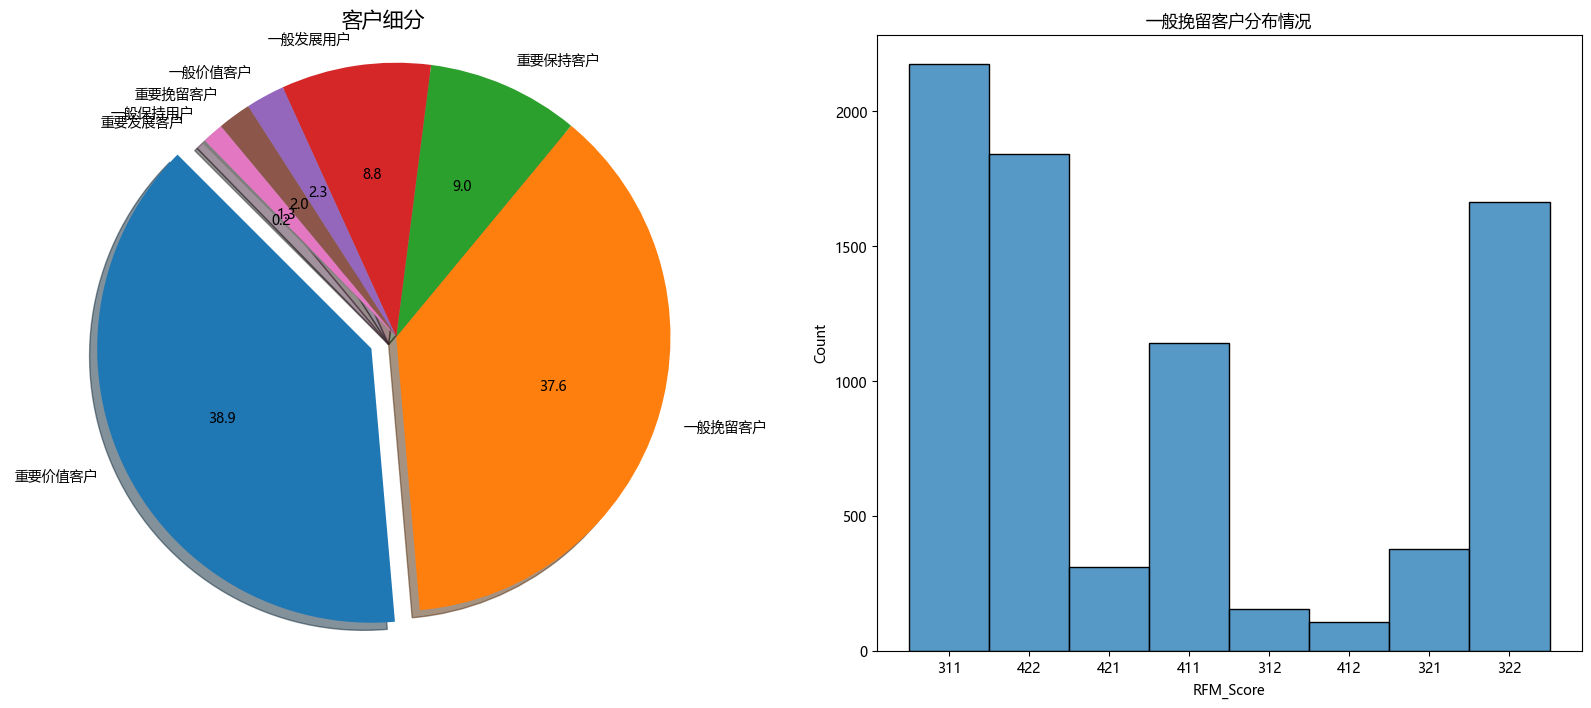

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

Customer_seg['Customer_Segmentation'].value_counts().plot.pie(ax=ax1,
                                        startangle=135, explode=(0.1,0,0,0,0,0,0,0),autopct='%.1f',shadow=True)
ax1.set_title("客户细分",size=15)
ax1.set_ylabel(" ")
ax1.axis('equal') 

churned=Customer_seg[(Customer_seg['RFM_Score_Level']=='000')]
sns.histplot(churned['RFM_Score'], bins=10, ax=ax2)
ax2.set_xlabel('RFM_Score')
ax2.set_ylabel('Count')
ax2.set_title('一般挽留客户分布情况')

plt.show()

客户量排名前4的分别是重要价值客户，重要保持客户，一般发展客户，一般挽留客户，针对这类客户，可以采取以下行动：   
- 重要价值客户（38.9%）：这类客户是最有价值的客户，他们最近消费时间近，消费频率高，消费金额高。针对这类客户，应该提供VIP服务，如优先配送、专属客服、定制产品等，以保持他们的高活跃度和高消费水平。同时，可以通过积分兑换、会员卡、优惠券等方式增加他们的粘性和忠诚度。  
- 一般挽留客户（37.6%）：这类客户是即将流失的客户，他们最近消费时间远，消费频率低，消费金额低。针对这类客户，应该主动联系他们，调查他们的满意度和流失原因，并根据情况提供相应的补救措施。同时，可以通过发送感谢信、问候语、回访电话等方式表达关怀和重视。  
- 重要保持客户（9.0%）：这类客户是一段时间没有消费的忠实客户，他们消费频率高，消费金额高，但最近消费时间远。针对这类客户，应该主动与他们保持联系，了解他们的需求和反馈，提供满意的售后服务和问题解决方案。同时，可以通过发送新品推荐、活动邀请、节日祝福等方式刺激他们的再次购买意愿。  
- 一般发展客户（8.8%）：这类客户是有潜力的客户，他们最近消费时间近，但消费频率低，消费金额低。针对这类客户，应该提高他们的认知度和信任度，通过展示产品的优势、评价、案例等方式增加他们的购买信心。同时，可以通过赠送样品、试用期、折扣等方式降低他们的购买成本和风险。  


# 数据建模

利用机器学习模型对数据集进行训练验证选出合适的模型，并用于检测欺诈和延迟交付。

针对涉嫌欺诈和延迟交货的订单创建了两个新列，将其进行二元分类，从而有助于更好地衡量不同模型的性能。

In [41]:
train_data=data.copy()

train_data['fraud'] = np.where(train_data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)
train_data['late_delivery']=np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)

删除重复值列,以及不需要的列。

In [42]:
train_data.drop(['Delivery Status','Late_delivery_risk','Order Status','order_month_year','order date (DateOrders)'], axis=1, inplace=True)

In [43]:
train_data.dtypes

Type                              object
Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Benefit per order                float64
Sales per customer               float64
Category Id                        int64
Category Name                     object
Customer City                     object
Customer Country                  object
Customer Id                        int64
Customer Segment                  object
Customer State                    object
Customer Zipcode                 float64
Department Id                      int64
Department Name                   object
Market                            object
Order City                        object
Order Country                     object
Order Customer Id                  int64
Order Id                           int64
Order Item Cardprod Id             int64
Order Item Discount              float64
Order Item Discount Rate         float64
Order Item Id                      int64
Order Item Produ

数据类型转换

In [44]:
# 创建一个LabelEncoder对象，用来对数据进行标签编码
le = preprocessing.LabelEncoder()

train_data['Customer Country']  = le.fit_transform(train_data['Customer Country'])
train_data['Market']            = le.fit_transform(train_data['Market'])
train_data['Type']              = le.fit_transform(train_data['Type'])
train_data['Product Name']      = le.fit_transform(train_data['Product Name'])
train_data['Customer Segment']  = le.fit_transform(train_data['Customer Segment'])
train_data['Customer State']    = le.fit_transform(train_data['Customer State'])
train_data['Order Region']      = le.fit_transform(train_data['Order Region'])
train_data['Order City']        = le.fit_transform(train_data['Order City'])
train_data['Category Name']     = le.fit_transform(train_data['Category Name'])
train_data['Customer City']     = le.fit_transform(train_data['Customer City'])
train_data['Department Name']   = le.fit_transform(train_data['Department Name'])
train_data['Order State']       = le.fit_transform(train_data['Order State'])
train_data['Shipping Mode']     = le.fit_transform(train_data['Shipping Mode'])
train_data['order_week_day']    = le.fit_transform(train_data['order_week_day'])
train_data['Order Country']     = le.fit_transform(train_data['Order Country'])
train_data['Customer Full Name']= le.fit_transform(train_data['Customer Full Name'])

train_data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Id,Category Name,Customer City,Customer Country,Customer Id,...,Product Price,Shipping Mode,Customer Full Name,order_year,order_month,order_week_day,order_hour,TotalPrice,fraud,late_delivery
0,1,3,4,91.250000,314.640015,73,40,66,1,20755,...,327.75,3,1876,2018,1,2,22,327.75,0,0
1,3,5,4,-249.089996,311.359985,73,40,66,1,19492,...,327.75,3,5378,2018,1,5,12,327.75,0,1
2,0,4,4,-247.779999,309.720001,73,40,452,0,19491,...,327.75,3,4429,2018,1,5,12,327.75,0,0
3,1,3,4,22.860001,304.809998,73,40,285,0,19490,...,327.75,3,12929,2018,1,5,11,327.75,0,0
4,2,2,4,134.210007,298.250000,73,40,66,1,19489,...,327.75,3,10638,2018,1,5,11,327.75,0,0


In [45]:
train_data.shape

(180519, 45)

### 数据分割

In [46]:
xf=train_data.loc[:, train_data.columns != 'fraud']

yf=train_data['fraud']
#数据分割
xf_train, xf_test,yf_train,yf_test = train_test_split(xf,yf,test_size = 0.2,random_state = 42)

xl=train_data.loc[:, train_data.columns != 'late_delivery']

yl=train_data['late_delivery']
#数据分割
xl_train, xl_test,yl_train,yl_test = train_test_split(xl,yl,test_size = 0.2, random_state = 42)

### 数据标准化

In [47]:
# 创建一个StandardScaler对象，用来对数据进行标准化处理
sc = StandardScaler()
xf_train=sc.fit_transform(xf_train)
xf_test=sc.transform(xf_test)
xl_train=sc.fit_transform(xl_train)
xl_test=sc.transform(xl_test)

### 评估模型

In [48]:
def classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test):
    model_f=model_f.fit(xf_train,yf_train) 
    model_l=model_l.fit(xl_train,yl_train) 
    yf_pred=model_f.predict(xf_test)
    yl_pred=model_l.predict(xl_test)  
    accuracy_f=accuracy_score(yf_pred, yf_test) 
    accuracy_l=accuracy_score(yl_pred, yl_test) 
    recall_f=recall_score(yf_pred, yf_test) 
    recall_l=recall_score(yl_pred, yl_test)
    conf_f=confusion_matrix(yf_test, yf_pred)
    conf_l=confusion_matrix(yl_test, yl_pred)
    f1_f=f1_score(yf_test, yf_pred)
    f1_l=f1_score(yl_test, yl_pred)
    print('模型名称 :',model_f)
    print('订单欺诈分类的准确率      :', '{:.2%}'.format(accuracy_f))
    print('订单欺诈分类的召回率      :', '{:.2%}'.format(recall_f))
    print('订单欺诈分类的混淆矩阵    :\n',  (conf_f))
    print('订单欺诈分类的 F1 score  :', '{:.2%}'.format(f1_f))
    print('订单延误分类的准确率      :', '{:.2%}'.format(accuracy_l))
    print('订单延误分类的召回率      :', '{:.2%}'.format(recall_l))
    print('订单延误分类的混淆矩阵    : \n',(conf_l))
    print('订单延误分类的 F1 score  :', '{:.2%}'.format(f1_l))
    return model_f,accuracy_f,recall_f,f1_f,accuracy_l,recall_l,f1_l

### Logistic分类

In [49]:
ModelEvaluation=[]
model_f = LogisticRegression(solver='lbfgs',random_state=0) 
model_l = LogisticRegression(solver='lbfgs',random_state=0) 

model_f,accuracy_f,recall_f,f1_f,accuracy_l,recall_l,f1_l=classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)
ModelEvaluation.append([model_f,'{:.2%}'.format(accuracy_f),'{:.2%}'.format(recall_f),'{:.2%}'.format(f1_f),'{:.2%}'.format(accuracy_l),'{:.2%}'.format(recall_l),'{:.2%}'.format(f1_l)])

模型名称 : LogisticRegression(random_state=0)
订单欺诈分类的准确率      : 97.78%
订单欺诈分类的召回率      : 58.12%
订单欺诈分类的混淆矩阵    :
 [[35125   129]
 [  671   179]]
订单欺诈分类的 F1 score  : 30.92%
订单延误分类的准确率      : 98.85%
订单延误分类的召回率      : 97.94%
订单延误分类的混淆矩阵    : 
 [[15891   416]
 [    0 19797]]
订单延误分类的 F1 score  : 98.96%


### 贝叶斯分类

In [50]:
model_f = GaussianNB()
model_l = GaussianNB()

model_f,accuracy_f,recall_f,f1_f,accuracy_l,recall_l,f1_l=classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)
ModelEvaluation.append([model_f,'{:.2%}'.format(accuracy_f),'{:.2%}'.format(recall_f),'{:.2%}'.format(f1_f),'{:.2%}'.format(accuracy_l),'{:.2%}'.format(recall_l),'{:.2%}'.format(f1_l)])

模型名称 : GaussianNB()
订单欺诈分类的准确率      : 87.85%
订单欺诈分类的召回率      : 16.23%
订单欺诈分类的混淆矩阵    :
 [[30867  4387]
 [    0   850]]
订单欺诈分类的 F1 score  : 27.93%
订单延误分类的准确率      : 57.23%
订单延误分类的召回率      : 56.19%
订单延误分类的混淆矩阵    : 
 [[  888 15419]
 [   21 19776]]
订单延误分类的 F1 score  : 71.92%


### 支持向量机

In [51]:
model_f = svm.LinearSVC()
model_l = svm.LinearSVC()

model_f,accuracy_f,recall_f,f1_f,accuracy_l,recall_l,f1_l=classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)
ModelEvaluation.append([model_f,'{:.2%}'.format(accuracy_f),'{:.2%}'.format(recall_f),'{:.2%}'.format(f1_f),'{:.2%}'.format(accuracy_l),'{:.2%}'.format(recall_l),'{:.2%}'.format(f1_l)])

模型名称 : LinearSVC()
订单欺诈分类的准确率      : 97.75%
订单欺诈分类的召回率      : 56.75%
订单欺诈分类的混淆矩阵    :
 [[35129   125]
 [  686   164]]
订单欺诈分类的 F1 score  : 28.80%
订单延误分类的准确率      : 98.85%
订单延误分类的召回率      : 97.94%
订单延误分类的混淆矩阵    : 
 [[15891   416]
 [    0 19797]]
订单延误分类的 F1 score  : 98.96%


### K 最近邻分类

In [52]:
model_f = KNeighborsClassifier(n_neighbors=1)
model_l = KNeighborsClassifier(n_neighbors=1)

model_f,accuracy_f,recall_f,f1_f,accuracy_l,recall_l,f1_l=classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)
ModelEvaluation.append([model_f,'{:.2%}'.format(accuracy_f),'{:.2%}'.format(recall_f),'{:.2%}'.format(f1_f),'{:.2%}'.format(accuracy_l),'{:.2%}'.format(recall_l),'{:.2%}'.format(f1_l)])

模型名称 : KNeighborsClassifier(n_neighbors=1)
订单欺诈分类的准确率      : 97.39%
订单欺诈分类的召回率      : 42.72%
订单欺诈分类的混淆矩阵    :
 [[34888   366]
 [  577   273]]
订单欺诈分类的 F1 score  : 36.67%
订单延误分类的准确率      : 80.71%
订单延误分类的召回率      : 83.27%
订单延误分类的混淆矩阵    : 
 [[13080  3227]
 [ 3737 16060]]
订单延误分类的 F1 score  : 82.18%


### 线性判别分析

In [53]:
model_f = LinearDiscriminantAnalysis()
model_l = LinearDiscriminantAnalysis()

model_f,accuracy_f,recall_f,f1_f,accuracy_l,recall_l,f1_l=classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)
ModelEvaluation.append([model_f,'{:.2%}'.format(accuracy_f),'{:.2%}'.format(recall_f),'{:.2%}'.format(f1_f),'{:.2%}'.format(accuracy_l),'{:.2%}'.format(recall_l),'{:.2%}'.format(f1_l)])

模型名称 : LinearDiscriminantAnalysis()
订单欺诈分类的准确率      : 97.88%
订单欺诈分类的召回率      : 56.50%
订单欺诈分类的混淆矩阵    :
 [[34966   288]
 [  476   374]]
订单欺诈分类的 F1 score  : 49.47%
订单延误分类的准确率      : 98.36%
订单延误分类的召回率      : 97.69%
订单延误分类的混淆矩阵    : 
 [[15841   466]
 [  125 19672]]
订单延误分类的 F1 score  : 98.52%


### 随机森林分类

In [54]:
model_f = RandomForestClassifier()
model_l = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

model_f,accuracy_f,recall_f,f1_f,accuracy_l,recall_l,f1_l=classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)
ModelEvaluation.append([model_f,'{:.2%}'.format(accuracy_f),'{:.2%}'.format(recall_f),'{:.2%}'.format(f1_f),'{:.2%}'.format(accuracy_l),'{:.2%}'.format(recall_l),'{:.2%}'.format(f1_l)])

模型名称 : RandomForestClassifier()
订单欺诈分类的准确率      : 98.73%
订单欺诈分类的召回率      : 97.33%
订单欺诈分类的混淆矩阵    :
 [[35243    11]
 [  449   401]]
订单欺诈分类的 F1 score  : 63.55%
订单延误分类的准确率      : 98.64%
订单延误分类的召回率      : 97.58%
订单延误分类的混淆矩阵    : 
 [[15817   490]
 [    0 19797]]
订单延误分类的 F1 score  : 98.78%


### Extra树分类

In [55]:
model_f = ExtraTreesClassifier(n_estimators=100, max_depth=None,random_state=0)
model_l = ExtraTreesClassifier(n_estimators=100, max_depth=None,random_state=0)

model_f,accuracy_f,recall_f,f1_f,accuracy_l,recall_l,f1_l=classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)
ModelEvaluation.append([model_f,'{:.2%}'.format(accuracy_f),'{:.2%}'.format(recall_f),'{:.2%}'.format(f1_f),'{:.2%}'.format(accuracy_l),'{:.2%}'.format(recall_l),'{:.2%}'.format(f1_l)])

模型名称 : ExtraTreesClassifier(random_state=0)
订单欺诈分类的准确率      : 98.66%
订单欺诈分类的召回率      : 99.46%
订单欺诈分类的混淆矩阵    :
 [[35252     2]
 [  482   368]]
订单欺诈分类的 F1 score  : 60.33%
订单延误分类的准确率      : 99.15%
订单延误分类的召回率      : 98.47%
订单延误分类的混淆矩阵    : 
 [[15999   308]
 [    0 19797]]
订单延误分类的 F1 score  : 99.23%


### 决策树分类

In [56]:
model_f = tree.DecisionTreeClassifier()
model_l = tree.DecisionTreeClassifier()

model_f,accuracy_f,recall_f,f1_f,accuracy_l,recall_l,f1_l=classifiermodel(model_f,model_l,xf_train, xf_test,yf_train,yf_test,xl_train, xl_test,yl_train,yl_test)
ModelEvaluation.append([model_f,'{:.2%}'.format(accuracy_f),'{:.2%}'.format(recall_f),'{:.2%}'.format(f1_f),'{:.2%}'.format(accuracy_l),'{:.2%}'.format(recall_l),'{:.2%}'.format(f1_l)])

模型名称 : DecisionTreeClassifier()
订单欺诈分类的准确率      : 99.09%
订单欺诈分类的召回率      : 81.39%
订单欺诈分类的混淆矩阵    :
 [[35099   155]
 [  172   678]]
订单欺诈分类的 F1 score  : 80.57%
订单延误分类的准确率      : 99.43%
订单延误分类的召回率      : 99.48%
订单延误分类的混淆矩阵    : 
 [[16205   102]
 [  104 19693]]
订单延误分类的 F1 score  : 99.48%


### 模型评估

In [57]:
classification_comparision=pd.DataFrame(ModelEvaluation,columns = ['模型名称','订单欺诈分类的准确率','订单欺诈分类的召回率','订单欺诈分类的 F1 score',
                                                                           '订单延误分类的准确率','订单延误分类的召回率','订单延误分类的 F1 score'])
classification_comparision['模型名称']=['逻辑回归','贝叶斯分类','支持向量机','K最邻近值','线性分类','随机森林分类','Extra树分类','决策树分类']

classification_comparision

,模型名称,订单欺诈分类的准确率,订单欺诈分类的召回率,订单欺诈分类的 F1 score,订单延误分类的准确率,订单延误分类的召回率,订单延误分类的 F1 score
0,逻辑回归,97.78%,58.12%,30.92%,98.85%,97.94%,98.96%
1,贝叶斯分类,87.85%,16.23%,27.93%,57.23%,56.19%,71.92%
2,支持向量机,97.75%,56.75%,28.80%,98.85%,97.94%,98.96%
3,K最邻近值,97.39%,42.72%,36.67%,80.71%,83.27%,82.18%
4,线性分类,97.88%,56.50%,49.47%,98.36%,97.69%,98.52%
5,随机森林分类,98.73%,97.33%,63.55%,98.64%,97.58%,98.78%
6,Extra树分类,98.66%,99.46%,60.33%,99.15%,98.47%,99.23%
7,决策树分类,99.09%,81.39%,80.57%,99.43%,99.48%,99.48%


很明显决策树分类器对于分类类型表现更好，欺诈检测的 F1 分数几乎为 80%，延迟交付判别的 F1 分数为 99%。

### 交叉验证

In [58]:

def cross_validation_model(model_f,model_l,xf,yf,xl,yl):
    model_f= model_f.fit(xf,yf)
    model_l = model_l.fit(xl,yl)
    scores_f = cross_val_score(model_f, xf, yf, cv=6)
    scores_l = cross_val_score(model_l, xl, yl, cv=6)
    print('模型名称',model_f)
    print('订单欺诈交叉验证的准确率 : %0.2f (+/- %0.2f)' % (scores_f.mean(), scores_f.std() * 2))
    print('订单延误交叉验证的准确率 : %0.2f (+/- %0.2f)' % (scores_l.mean(), scores_l.std() * 2))

In [59]:
cross_validation_model(model_f,model_l,xf,yf,xl,yl)

模型名称 DecisionTreeClassifier()
订单欺诈交叉验证的准确率 : 0.96 (+/- 0.05)
订单延误交叉验证的准确率 : 0.98 (+/- 0.02)


由于模型的交叉验证分数和准确度分数之间的差异非常小，因此可以确认数据既没有过度拟合也没有拟合不足，使用 sklearn 的特征重要性方法可以找到模型中哪个变量更重要。

### 重要特征分析

Text(1.3194444444444589, 0.5, '权重')

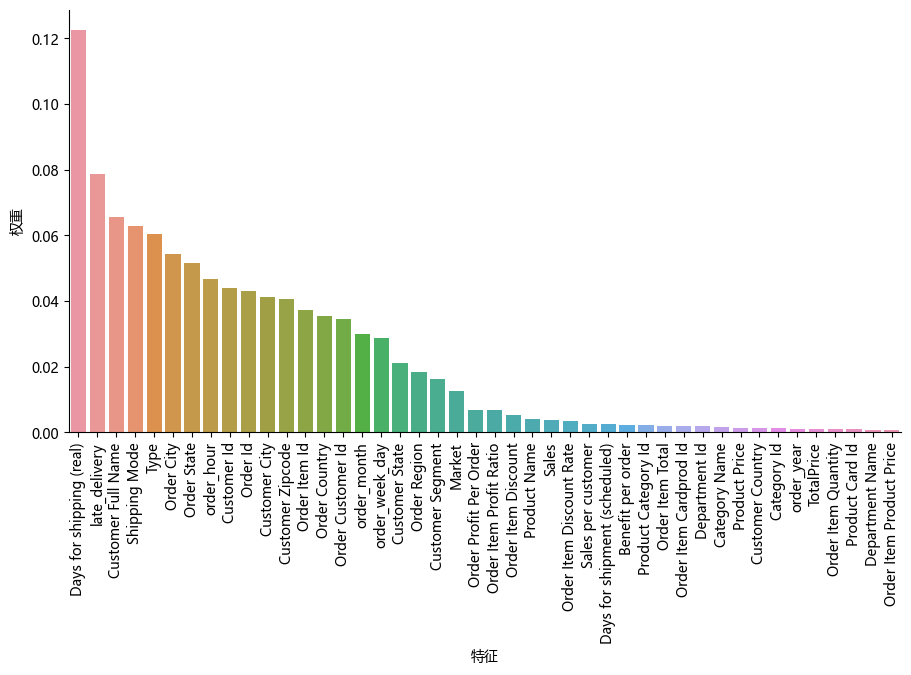

In [60]:
important_col=model_f.feature_importances_.argsort()
feat_imp=pd.DataFrame({'Variables':xf.columns[important_col],'importance':model_f.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)
plt.xlabel('特征')
plt.ylabel('权重')

对于订单欺诈来说，尽管欺诈检测与运输天数完全无关，但它的重要性权重约为0.12，而所有其他重要参数（例如客户全名、运输方式、使用的付款类型）的重要性权重约为 0.07。


Text(9.444444444444459, 0.5, '权重')

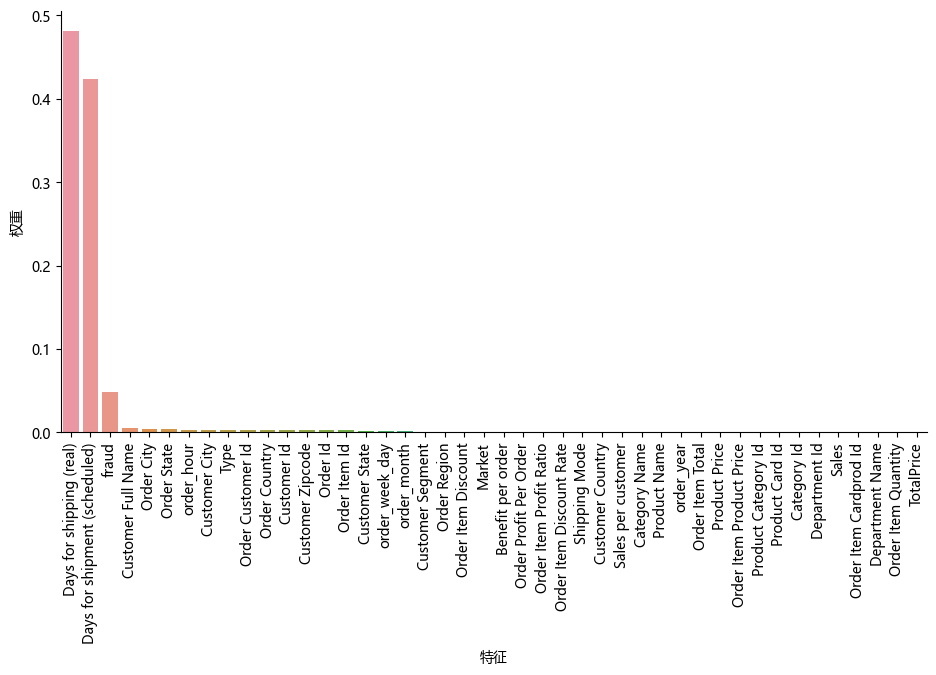

In [61]:
important_col=model_l.feature_importances_.argsort()
feat_imp=pd.DataFrame({'features':xl.columns[important_col],'importance':model_l.feature_importances_[important_col]})
feat_imp=feat_imp.sort_values(by='importance',ascending=False)
ax = sns.catplot(x='features', y = 'importance', data=feat_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)
plt.xlabel('特征')
plt.ylabel('权重')

可以看出对于交付延误情况分析中，运输天数的列几乎具有 90% 的重要性。
另外，订单欺诈分析和交付延误分析中相同关键变量占据了绝大部分权重，这有点不正常，所以尝试删除关键变量，看模型能够预测得如何。

In [62]:
new_data=train_data.copy()

In [63]:

new_data=new_data.drop(['Days for shipping (real)','Days for shipment (scheduled)'],axis=1)

In [64]:
new_xf=new_data.loc[:, new_data.columns != 'fraud']

new_yf=train_data['fraud']

new_xf_train, new_xf_test,new_yf_train,new_yf_test = train_test_split(new_xf,new_yf,test_size = 0.2,random_state = 42)

new_xl=new_data.loc[:, new_data.columns != 'late_delivery']

new_yl=train_data['late_delivery']

new_xl_train, new_xl_test,new_yl_train,new_yl_test = train_test_split(new_xl,new_yl,test_size = 0.2,random_state = 42)

数据标准化

In [65]:
new_xf_train=sc.fit_transform(new_xf_train)
new_xf_test=sc.transform(new_xf_test)
new_xl_train=sc.fit_transform(new_xl_train)
new_xl_test=sc.transform(new_xl_test)

模型评估

In [66]:
new_model_f=tree.DecisionTreeClassifier()
new_model_l=tree.DecisionTreeClassifier()
new_model_f=new_model_f.fit(new_xf_train,new_yf_train) 
new_model_l=new_model_l.fit(new_xl_train,new_yl_train) 
yf_pred=new_model_f.predict(new_xf_test)
yl_pred=new_model_l.predict(new_xl_test)  
accuracy_f=accuracy_score(yf_pred, new_yf_test) 
accuracy_l=accuracy_score(yl_pred, new_yl_test) 
recall_f=recall_score(yf_pred, new_yf_test) 
recall_l=recall_score(yl_pred, new_yl_test)
conf_f=confusion_matrix(new_yf_test, yf_pred)
conf_l=confusion_matrix(new_yl_test, yl_pred)
f1_f=f1_score(new_yf_test, yf_pred)
f1_l=f1_score(new_yl_test, yl_pred)
print('模型名称 :',new_model_f)
print('订单欺诈分类的准确率        :', '{:.2%}'.format(accuracy_f))
print('订单欺诈分类的召回率        :', '{:.2%}'.format(recall_f))
print('订单欺诈分类的混淆矩阵      :\n',  (conf_f))
print('订单欺诈分类的 F1 score     :', '{:.2%}'.format(f1_f))
print('订单延误分类的准确率         :', '{:.2%}'.format(accuracy_l))
print('订单延误分类的召回率         :', '{:.2%}'.format(recall_l))
print('订单延误分类的混淆矩阵       : \n',(conf_l))
print('订单延误分类的 F1 score      :', '{:.2%}'.format(f1_l))

模型名称 : DecisionTreeClassifier()
订单欺诈分类的准确率        : 98.96%
订单欺诈分类的召回率        : 77.75%
订单欺诈分类的混淆矩阵      :
 [[35064   190]
 [  186   664]]
订单欺诈分类的 F1 score     : 77.93%
订单延误分类的准确率         : 83.97%
订单延误分类的召回率         : 85.18%
订单延误分类的混淆矩阵       : 
 [[13357  2950]
 [ 2836 16961]]
订单延误分类的 F1 score      : 85.43%


可以看到即使删除运输天数变量，新模型的 F1 分数和准确率并未下降多少。

<Figure size 640x480 with 0 Axes>

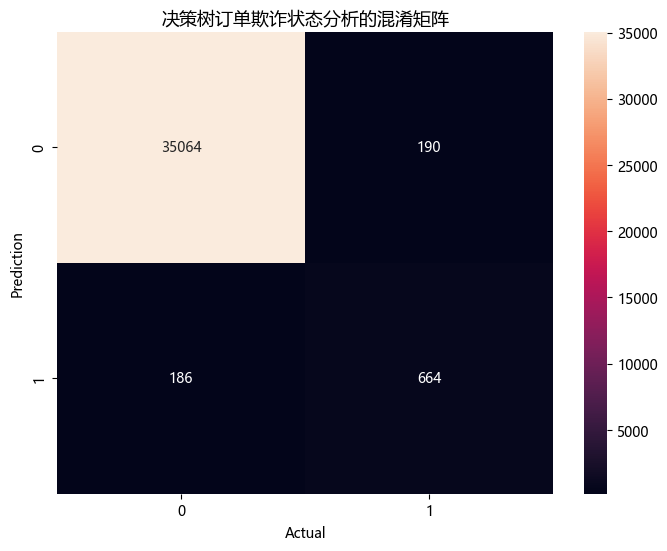

<Figure size 640x480 with 0 Axes>

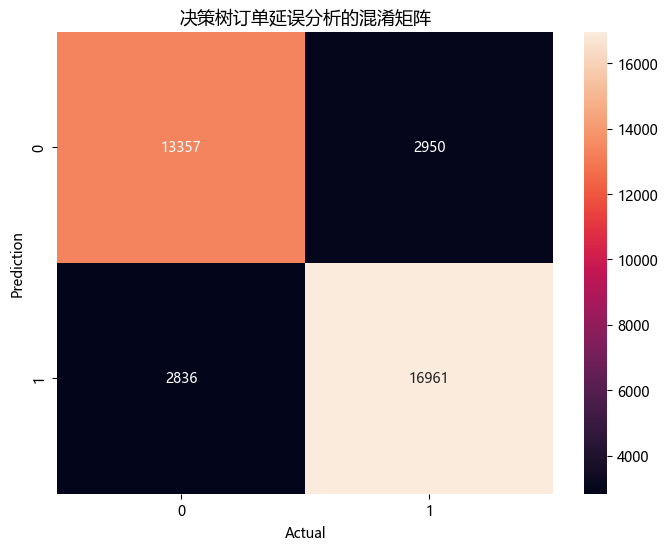

In [67]:
plt.figure(1)
data = np.array(conf_f)
data = data[:, :]
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True,fmt='g')
plt.title('决策树订单欺诈状态分析的混淆矩阵', fontsize=13)
plt.xlabel('Actual', fontsize=10)
plt.ylabel('Prediction', fontsize=10)
plt.show()
plt.figure(2)
data = np.array(conf_l)
data = data[:, :]
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True,fmt='g')
plt.title('决策树订单延误分析的混淆矩阵', fontsize=13)
plt.xlabel('Actual', fontsize=10)
plt.ylabel('Prediction', fontsize=10)
plt.show()

### 预测结果数据比较

In [68]:
#订单欺诈
data_comparision_f = pd.DataFrame({
    "Prediction": yf_pred,
    "Actual": new_yf_test
})
data_comparision_f.head(10)

,Prediction,Actual
80120,0,0
19670,0,0
114887,0,0
120110,0,0
56658,0,0
99465,0,0
40749,0,0
22688,0,0
154389,0,0
47301,0,0


In [69]:
#订单延误
data_comparision_l = pd.DataFrame({
    "Prediction": yl_pred,
    "Actual": new_yl_test
})
data_comparision_l.head(10)

,Prediction,Actual
80120,1,1
19670,1,1
114887,0,0
120110,1,1
56658,0,0
99465,1,1
40749,1,1
22688,0,0
154389,0,1
47301,1,0


# 总结

在分析DataCo公司的数据集后发现，西欧和中美洲都是销售额最高的地区，但该公司仅在这些地区损失了大部分收入。这两个地区都被怀疑是欺诈交易和延迟交货订单数量最多的地区。该公司的总销售额在 2017 年第三季度之前一直保持稳定，按季度增长10%，然后在2018年第一季度突然下降了近65%。10月和11月是全年销售额最多的月份。大多数人更喜欢通过借记卡付款，并且需要注意的是存在一定数额的订单欺诈，该公司曾被单个客户诈骗超过10万。所有有延迟交货风险的订单每次都会延迟交货。大多数鞋类、男鞋、女装类产品的订单都导致延迟交货，这些产品被怀疑是欺诈最多的。与其他分类机器学习模型相比，决策树模型在识别延迟交货和订单欺诈方面比其他模型表现更好。